In [ ]:
import re
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from typing import Optional, Tuple, Dict
from collections import Counter

from neuralnetlib.layers import MultiHeadAttention, PositionalEncoding, AddNorm, FeedForward, TransformerEncoderLayer, TransformerDecoderLayer, Embedding
from neuralnetlib.preprocessing import PCA, Tokenizer, pad_sequences, normalize_gradient

logging.getLogger('matplotlib').setLevel(logging.ERROR)



Debugging Embedding Layer


INFO:embedding_debug:Starting embedding forward pass
INFO:embedding_debug:Initializing embedding weights



French Embedding Layer:
------------------------------

Embedding Usage Statistics:
  unique_tokens: 2250
  total_tokens: 95000
  most_common_tokens: [(0, 321), (2, 844), (3, 1000), (4, 1000), (5, 81486)]
  unused_tokens: 1
  special_token_usage: {'token_0': 81486, 'token_1': 0, 'token_2': 1000, 'token_3': 1000}

Token Distribution:
  Total tokens: 95000
  Unique tokens: 2250
  Most common tokens: [(0, 81486), (2, 1000), (3, 1000), (4, 844), (5, 321)]
  Special tokens usage:
    Token 0: 81486
    Token 1: 0
    Token 2: 1000
    Token 3: 1000

Visualizing French Embeddings:


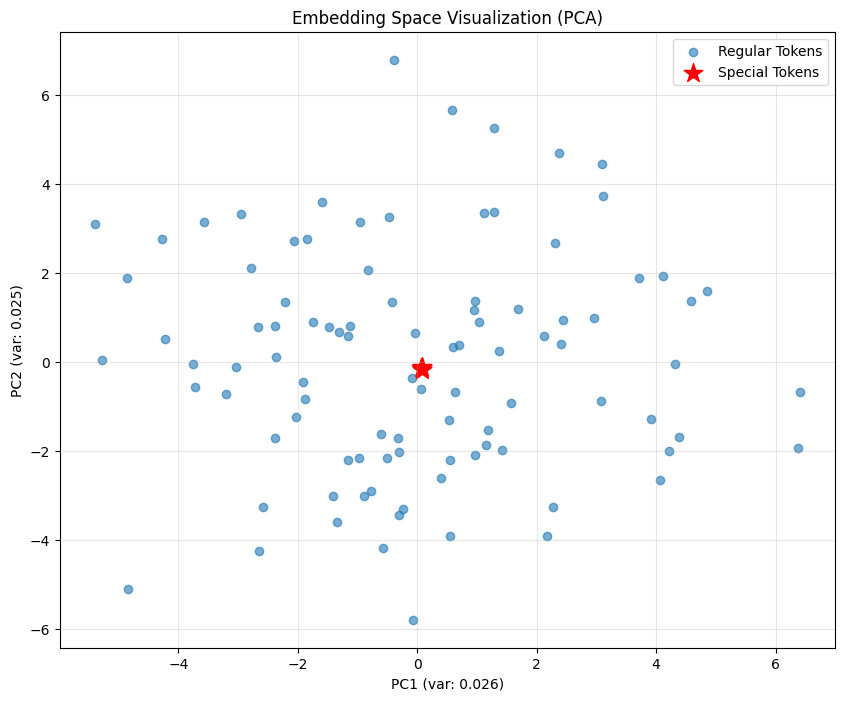

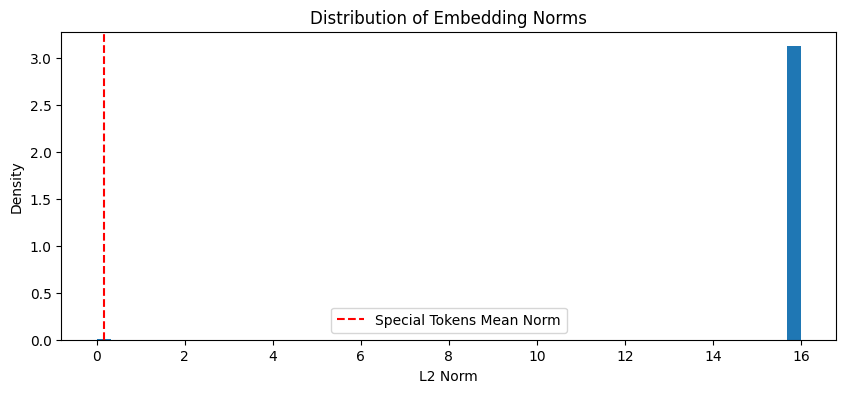

INFO:embedding_debug:Starting embedding forward pass
INFO:embedding_debug:Initializing embedding weights



English Embedding Layer:
------------------------------

Visualizing English Embeddings:


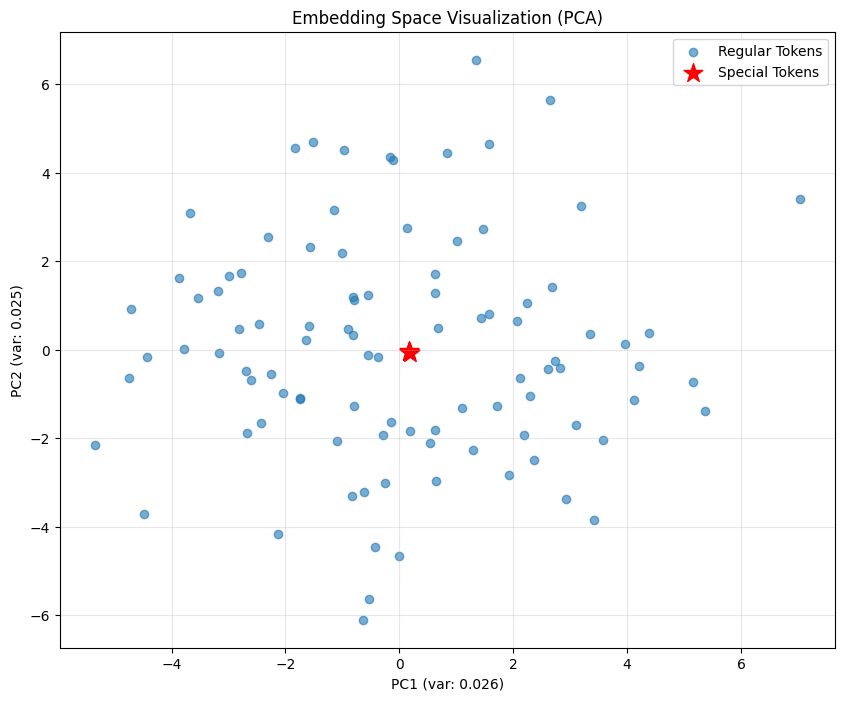

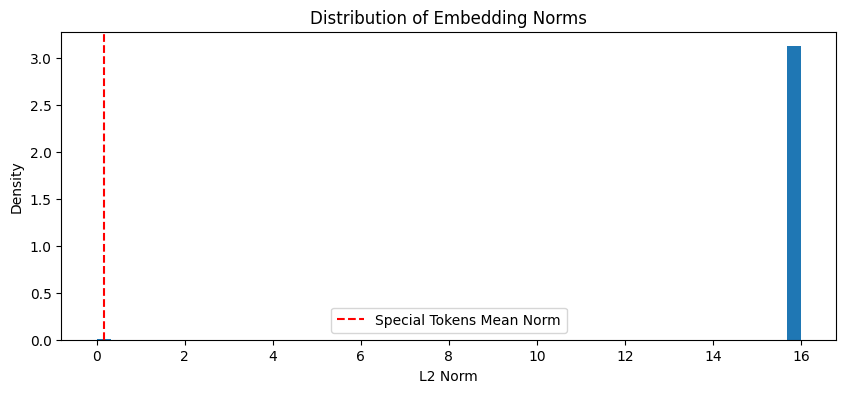

INFO:embedding_debug:Starting embedding backward pass
INFO:embedding_debug:Starting embedding backward pass



Gradient Statistics:
------------------------------

French Embedding Gradients:

weight_gradients:
  mean: 3.177992362772383e-06
  std: 0.001317319152415452
  max: 0.007659720596505566
  norm: 1.0000000000000013
  zero_ratio: 0.000888494002665482

special_token_gradients:
  token_0: 0.0
  token_1: 0.0
  token_2: 0.0007739941629960079
  token_3: 0.0007896559977932474

English Embedding Gradients:

weight_gradients:
  mean: 1.3757969063939104e-06
  std: 0.0014088581324122626
  max: 0.008870658112310983
  norm: 0.999999999999999
  zero_ratio: 0.0010162601626016261

special_token_gradients:
  token_0: 0.0
  token_1: 0.0
  token_2: 0.0008291141372384901
  token_3: 0.0008145898481110599


In [2]:
class DebugEmbedding(Embedding):
    def __init__(self, *args, **kwargs):
        logging.basicConfig(level=logging.DEBUG)
        self.logger = logging.getLogger("embedding_debug")
        self.debug_info = {}
        super().__init__(*args, **kwargs)

    def check_numerical_stability(self, tensor: np.ndarray, name: str) -> None:
        if np.any(np.isnan(tensor)):
            self.logger.error(f"NaN values detected in {name}")
            raise ValueError(f"NaN values detected in {name}")
        if np.any(np.isinf(tensor)):
            self.logger.error(f"Inf values detected in {name}")
            raise ValueError(f"Inf values detected in {name}")

    def analyze_tensor(self, tensor: np.ndarray, name: str) -> dict:
        stats = {
            'mean': float(np.mean(tensor)),
            'std': float(np.std(tensor)),
            'max': float(np.max(tensor)),
            'min': float(np.min(tensor)),
            'shape': tensor.shape,
            'norm': float(np.linalg.norm(tensor))
        }
        self.debug_info[name] = stats
        return stats

    def analyze_embedding_usage(self, input_data: np.ndarray) -> dict:
        unique_tokens, counts = np.unique(input_data, return_counts=True)
        usage_stats = {
            'unique_tokens': len(unique_tokens),
            'total_tokens': int(np.prod(input_data.shape)),
            'most_common_tokens': [
                (int(token), int(count)) 
                for token, count in zip(unique_tokens[np.argsort(-counts)[:5]], 
                                     np.sort(counts)[-5:])
            ],
            'unused_tokens': int(np.sum(np.bincount(input_data.flatten(), 
                                                   minlength=self.input_dim) == 0)),
            'special_token_usage': {
                f'token_{i}': int(np.sum(input_data == i))
                for i in range(4)  # Special tokens [0,1,2,3]
            }
        }
        self.debug_info['embedding_usage'] = usage_stats
        return usage_stats

    def visualize_embeddings(self, num_tokens: int = 100) -> None:
        if self.weights is None:
            self.logger.warning("No embeddings available to visualize")
            return
            
        tokens_to_viz = min(num_tokens, self.input_dim)
        embeddings = self.weights[:tokens_to_viz]
        
        pca = PCA(n_components=2)
        embeddings_2d = pca.fit_transform(embeddings)
        
        plt.figure(figsize=(10, 8))
        
        special_tokens = embeddings_2d[:4]
        regular_tokens = embeddings_2d[4:]
        
        plt.scatter(regular_tokens[:, 0], regular_tokens[:, 1], 
                   alpha=0.6, label='Regular Tokens')
        plt.scatter(special_tokens[:, 0], special_tokens[:, 1], 
                   marker='*', s=200, c='red', label='Special Tokens')
        
        plt.title('Embedding Space Visualization (PCA)')
        plt.xlabel(f'PC1 (var: {pca.explained_variance_ratio[0]:.3f})')
        plt.ylabel(f'PC2 (var: {pca.explained_variance_ratio[1]:.3f})')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        plt.figure(figsize=(10, 4))
        norms = np.linalg.norm(self.weights, axis=1)
        plt.hist(norms, bins=50, density=True)
        plt.axvline(norms[:4].mean(), color='r', linestyle='--', 
                   label='Special Tokens Mean Norm')
        plt.title('Distribution of Embedding Norms')
        plt.xlabel('L2 Norm')
        plt.ylabel('Density')
        plt.legend()
        plt.show()

    def analyze_gradient_statistics(self) -> dict:
        if not hasattr(self, 'd_weights'):
            return {}
            
        grad_stats = {
            'weight_gradients': {
                'mean': float(np.mean(self.d_weights)),
                'std': float(np.std(self.d_weights)),
                'max': float(np.max(np.abs(self.d_weights))),
                'norm': float(np.linalg.norm(self.d_weights)),
                'zero_ratio': float(np.mean(self.d_weights == 0))
            },
            'special_token_gradients': {
                f'token_{i}': float(np.linalg.norm(self.d_weights[i]))
                for i in range(4)
            }
        }
        self.debug_info['gradient_stats'] = grad_stats
        return grad_stats

    def initialize_weights(self):
        self.logger.info("Initializing embedding weights")
        super().initialize_weights()
        self.analyze_tensor(self.weights, 'initial_weights')
        
        special_token_stats = {
            f'token_{i}_norm': float(np.linalg.norm(self.weights[i]))
            for i in range(4)
        }
        self.debug_info['special_token_init'] = special_token_stats

    def forward_pass(self, input_data: np.ndarray) -> np.ndarray:
        self.logger.info("Starting embedding forward pass")
        
        self.analyze_tensor(input_data, 'input')
        self.analyze_embedding_usage(input_data)
        
        output = super().forward_pass(input_data)
        
        self.analyze_tensor(output, 'output')
        self.check_numerical_stability(output, 'output')
        
        return output

    def backward_pass(self, output_error: np.ndarray) -> np.ndarray:
        self.logger.info("Starting embedding backward pass")
        
        self.analyze_tensor(output_error, 'output_error')
        
        grad = super().backward_pass(output_error)
        
        self.analyze_gradient_statistics()
        
        return grad


def debug_embedding_layer(dataset_path: str = "dataset.tsv", limit: int = 1000, visualize: bool = True) -> None:
    print("\nDebugging Embedding Layer")
    print("=" * 50)
    
    df = pd.read_csv(dataset_path, sep="\t")
    df.iloc[:, 1] = df.iloc[:, 1].apply(
        lambda x: re.sub(r'\\x[a-fA-F0-9]{2}|\\u[a-fA-F0-9]{4}|\xa0|\u202f', ' ', x)
    )
    
    fr_sentences = df.iloc[:, 1].values.tolist()[:limit]
    en_sentences = df.iloc[:, 3].values.tolist()[:limit]
    
    fr_tokenizer = Tokenizer(filters="")
    en_tokenizer = Tokenizer(filters="")
    
    fr_tokenizer.fit_on_texts(fr_sentences, preprocess_ponctuation=True)
    en_tokenizer.fit_on_texts(en_sentences, preprocess_ponctuation=True)
    
    fr_embedding = DebugEmbedding(
        input_dim=len(fr_tokenizer.word_index),
        output_dim=256,
        input_length=None
    )
    
    en_embedding = DebugEmbedding(
        input_dim=len(en_tokenizer.word_index),
        output_dim=256,
        input_length=None
    )
    
    X = fr_tokenizer.texts_to_sequences(fr_sentences, preprocess_ponctuation=True, add_special_tokens=True)
    y = en_tokenizer.texts_to_sequences(en_sentences, preprocess_ponctuation=True, add_special_tokens=True)
    
    max_len_x = max(len(seq) for seq in X)
    max_len_y = max(len(seq) for seq in y)
    max_seq_len = max(max_len_x, max_len_y)
    
    X = pad_sequences(X, max_length=max_seq_len, padding='post', pad_value=fr_tokenizer.PAD_IDX)
    y = pad_sequences(y, max_length=max_seq_len, padding='post', pad_value=en_tokenizer.PAD_IDX)
    
    print("\nFrench Embedding Layer:")
    print("-" * 30)
    fr_output = fr_embedding.forward_pass(X)
    
    print("\nEmbedding Usage Statistics:")
    for name, stats in fr_embedding.debug_info['embedding_usage'].items():
        print(f"  {name}: {stats}")
    
    print("\nToken Distribution:")
    token_counts = Counter(X.flatten())
    print(f"  Total tokens: {sum(token_counts.values())}")
    print(f"  Unique tokens: {len(token_counts)}")
    print(f"  Most common tokens: {token_counts.most_common(5)}")
    print(f"  Special tokens usage:")
    for i in range(4):
        print(f"    Token {i}: {token_counts[i]}")
    
    if visualize:
        print("\nVisualizing French Embeddings:")
        fr_embedding.visualize_embeddings()
    
    print("\nEnglish Embedding Layer:")
    print("-" * 30)
    en_output = en_embedding.forward_pass(y)
    
    if visualize:
        print("\nVisualizing English Embeddings:")
        en_embedding.visualize_embeddings()
    
    fr_grad = np.random.normal(0, 0.1, fr_output.shape)
    en_grad = np.random.normal(0, 0.1, en_output.shape)
    
    fr_embedding.backward_pass(fr_grad)
    en_embedding.backward_pass(en_grad)
    
    print("\nGradient Statistics:")
    print("-" * 30)
    for lang, emb in [("French", fr_embedding), ("English", en_embedding)]:
        print(f"\n{lang} Embedding Gradients:")
        grad_stats = emb.debug_info.get('gradient_stats', {})
        for category, stats in grad_stats.items():
            print(f"\n{category}:")
            for metric, value in stats.items():
                print(f"  {metric}: {value}")
    
    return fr_embedding, en_embedding, fr_tokenizer, en_tokenizer

# Test avec votre dataset
fr_emb, en_emb, fr_tok, en_tok = debug_embedding_layer(
    dataset_path="dataset.tsv",
    limit=1000,
    visualize=True
)

Preparing data for attention layer debugging...


INFO:attention_debug:Starting forward pass
DEBUG:attention_debug:query shape: (32, 8, 95, 64)
DEBUG:attention_debug:key shape: (32, 8, 95, 64)
DEBUG:attention_debug:value shape: (32, 8, 95, 64)



Testing Self-Attention (French)...

Testing Self-Attention (French)...


INFO:attention_debug:Forward pass completed
DEBUG:attention_debug:final_output shape: (32, 95, 512)


French Self-Attention Output Shape: (32, 95, 512)

French Self-Attention Debug Summary:
-------------
Shape Information:
query_shape: (32, 8, 95, 64)
key_shape: (32, 8, 95, 64)
value_shape: (32, 8, 95, 64)
final_output_shape: (32, 95, 512)

Attention Statistics:
mean: 0.0105
std: 0.0312
max: 0.1736
min: 0.0000
sparsity: 0.8826
entropy: 2.3374

Visualizing French Self-Attention Pattern:


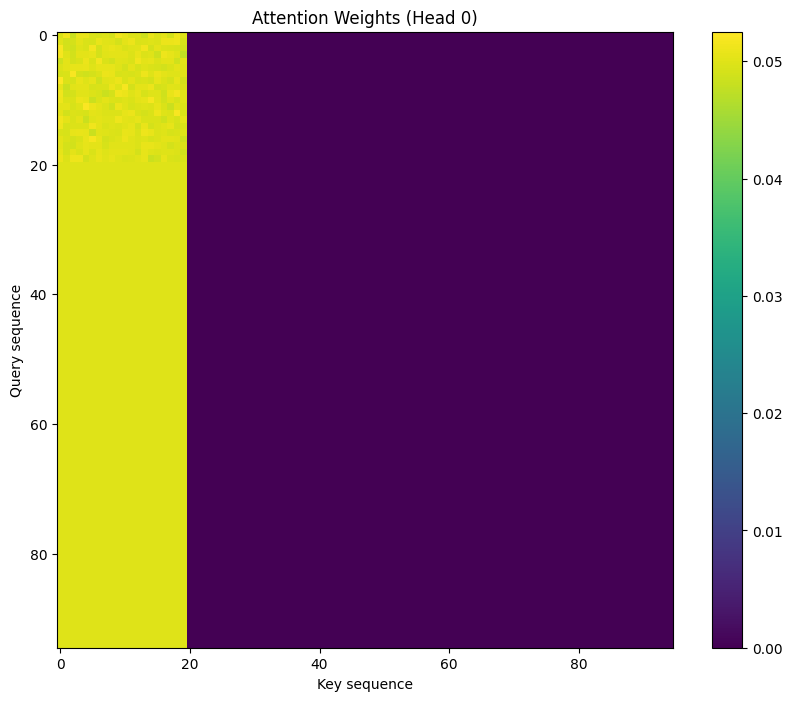

INFO:attention_debug:Starting forward pass
DEBUG:attention_debug:query shape: (32, 8, 95, 64)
DEBUG:attention_debug:key shape: (32, 8, 95, 64)
DEBUG:attention_debug:value shape: (32, 8, 95, 64)



Testing Cross-Attention...


INFO:attention_debug:Forward pass completed
DEBUG:attention_debug:final_output shape: (32, 95, 512)


Cross-Attention Output Shape: (32, 95, 512)

Cross-Attention Debug Summary:
-------------

Attention Statistics:
mean: 0.0105
std: 0.0332
max: 0.2069
min: 0.0000
sparsity: 0.8957
entropy: 2.2183

Visualizing Cross-Attention Pattern:


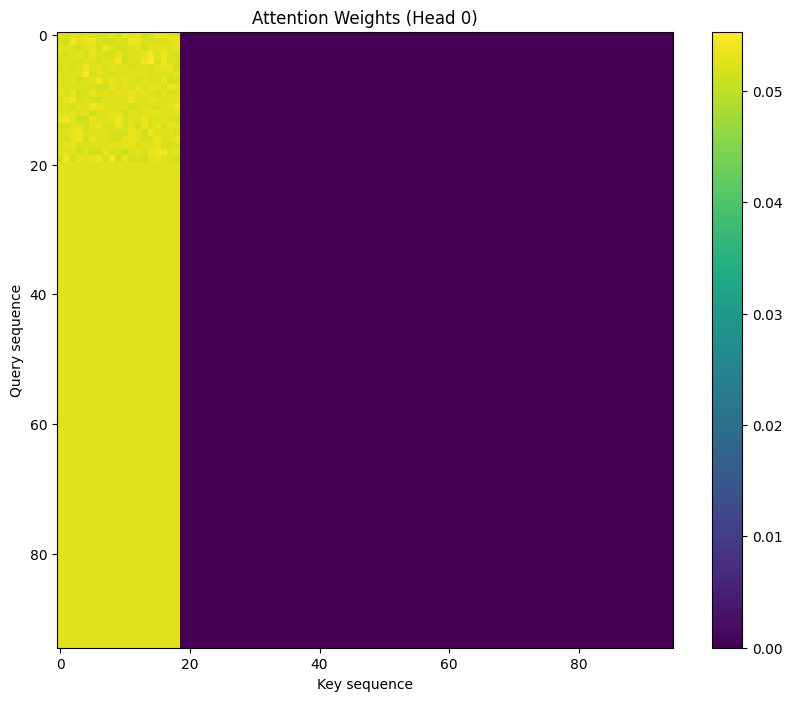

In [3]:
class DebugMultiHeadAttention(MultiHeadAttention):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.debug_info = {}
        self.setup_logging()
        
    def setup_logging(self):
        logging.basicConfig(level=logging.DEBUG)
        self.logger = logging.getLogger("attention_debug")
        
    def check_numerical_stability(self, tensor: np.ndarray, name: str) -> None:
        if np.any(np.isnan(tensor)):
            self.logger.error(f"NaN values detected in {name}")
            raise ValueError(f"NaN values detected in {name}")
        if np.any(np.isinf(tensor)):
            self.logger.error(f"Inf values detected in {name}")
            raise ValueError(f"Inf values detected in {name}")
            
    def log_shape_info(self, tensor: np.ndarray, name: str) -> None:
        """Log shape information of tensors"""
        self.logger.debug(f"{name} shape: {tensor.shape}")
        self.debug_info[f"{name}_shape"] = tensor.shape

    def analyze_attention_scores(self, scores: np.ndarray, stage: str) -> None:
        """Analyser les scores avant le softmax"""
        self.debug_info[f'attention_scores_{stage}'] = {
            'mean': float(np.mean(scores)),
            'std': float(np.std(scores)),
            'max': float(np.max(scores)),
            'min': float(np.min(scores))
        }

    def analyze_attention_pattern(self, weights: np.ndarray) -> None:
        """Analyser les motifs d'attention"""
        # Analyse de la concentration par position
        position_focus = np.mean(weights, axis=(0, 1))  # Moyenne sur batch et heads
        self.debug_info['attention_pattern'] = {
            'position_entropy': float(-np.sum(position_focus * np.log(position_focus + 1e-10))),
            'max_position_weight': float(np.max(position_focus)),
            'position_std': float(np.std(position_focus))
        }
    
    def analyze_attention_weights(self, weights: np.ndarray) -> Dict:
        analysis = {
            'mean': float(np.mean(weights)),
            'std': float(np.std(weights)),
            'max': float(np.max(weights)),
            'min': float(np.min(weights)),
            'sparsity': float(np.mean(weights < 0.01)),  # % of weights near zero
            'entropy': float(-np.sum(weights * np.log(weights + 1e-10), axis=-1).mean())
        }
        self.debug_info['attention_stats'] = analysis
        return analysis
        
    def visualize_attention(self, head_idx: int = 0, batch_idx: int = 0) -> None:
        if self.attention_weights is None:
            self.logger.warning("No attention weights available for visualization")
            return
            
        weights = self.attention_weights[batch_idx, head_idx]
        plt.figure(figsize=(10, 8))
        plt.imshow(weights, cmap='viridis')
        plt.colorbar()
        plt.title(f'Attention Weights (Head {head_idx})')
        plt.xlabel('Key sequence')
        plt.ylabel('Query sequence')
        plt.show()
        
    def _scaled_dot_product_attention(self, query: np.ndarray, key: np.ndarray, 
                                        value: np.ndarray, mask: np.ndarray = None,
                                        training: bool = True) -> np.ndarray:
        self.log_shape_info(query, 'query')
        self.log_shape_info(key, 'key')
        self.log_shape_info(value, 'value')

        if self.normalize_attention:
            query_norm = np.sqrt(np.sum(query * query, axis=-1, keepdims=True) + 1e-6)
            key_norm = np.sqrt(np.sum(key * key, axis=-1, keepdims=True) + 1e-6)
            
            query_normalized = query / query_norm
            key_normalized = key / key_norm
            
            matmul_qk = np.matmul(query_normalized, np.transpose(key_normalized, (0, 1, 3, 2)))
        else:
            matmul_qk = np.matmul(query, np.transpose(key, (0, 1, 3, 2)))

        self.check_numerical_stability(matmul_qk, 'QK matmul')

        d_k = key.shape[-1]
        
        scaling_factor = np.sqrt(d_k)
        scaled_attention_logits = matmul_qk / scaling_factor
        
        self.check_numerical_stability(scaled_attention_logits, 'scaled_attention_logits')

        MASKING_VALUE = -1e9
        if mask is not None:
            scaled_attention_logits += (mask * MASKING_VALUE)
        
        self.check_numerical_stability(scaled_attention_logits, 'scaled_attention_logits with mask')
        
        attention_weights = self._softmax_with_mask(scaled_attention_logits, mask)
        self.attention_weights = attention_weights
        
        self.check_numerical_stability(attention_weights, 'attention_weights')

        self.analyze_attention_weights(attention_weights)

        output = np.matmul(attention_weights, value)
        
        self.check_numerical_stability(output, 'attention_output')
        
        return output
        
    def forward_pass(self, inputs: np.ndarray | Tuple[np.ndarray, ...], 
                    mask: Optional[np.ndarray] = None,
                    training: bool = True) -> np.ndarray:
        """Override with debugging"""
        self.logger.info("Starting forward pass")
        self.debug_info.clear()
        
        output = super().forward_pass(inputs, mask, training)
        
        self.logger.info("Forward pass completed")
        self.log_shape_info(output, 'final_output')
        
        return output
        
    def get_debug_summary(self) -> Dict:
        if not self.debug_info:
            self.logger.warning("No debug information available")
            return {}
            
        summary = {
            'shapes': {k: v for k, v in self.debug_info.items() if 'shape' in k},
            'attention_stats': self.debug_info.get('attention_stats', {}),
        }
        return summary

def debug_attention_layer(attention_layer: DebugMultiHeadAttention,
                         dataset_path: str = "dataset.tsv",
                         limit: int = 1000,
                         embedding_dim: int = 512) -> None:
    print("Preparing data for attention layer debugging...")
    
    df = pd.read_csv(dataset_path, sep="\t")
    df.iloc[:, 1] = df.iloc[:, 1].apply(
        lambda x: re.sub(r'\\x[a-fA-F0-9]{2}|\\u[a-fA-F0-9]{4}|\xa0|\u202f', ' ', x)
    )
    
    fr_sentences = df.iloc[:, 1].values.tolist()[:limit]
    en_sentences = df.iloc[:, 3].values.tolist()[:limit]
    
    fr_tokenizer = Tokenizer(filters="")
    en_tokenizer = Tokenizer(filters="")
    
    fr_tokenizer.fit_on_texts(fr_sentences, preprocess_ponctuation=True)
    en_tokenizer.fit_on_texts(en_sentences, preprocess_ponctuation=True)
    
    X = fr_tokenizer.texts_to_sequences(fr_sentences, preprocess_ponctuation=True, add_special_tokens=True)
    y = en_tokenizer.texts_to_sequences(en_sentences, preprocess_ponctuation=True, add_special_tokens=True)
    
    max_len_x = max(len(seq) for seq in X)
    max_len_y = max(len(seq) for seq in y)
    max_seq_len = max(max_len_x, max_len_y)
    
    X = pad_sequences(X, max_length=max_seq_len, padding='post', pad_value=fr_tokenizer.PAD_IDX)
    y = pad_sequences(y, max_length=max_seq_len, padding='post', pad_value=en_tokenizer.PAD_IDX)
    
    embed_fr = Embedding(
        input_dim=len(fr_tokenizer.word_index), 
        output_dim=embedding_dim
    )
    embed_en = Embedding(
        input_dim=len(en_tokenizer.word_index), 
        output_dim=embedding_dim
    )
    
    fr_embed = embed_fr.forward_pass(X[:32])
    en_embed = embed_en.forward_pass(y[:32])
    
    print("\nTesting Self-Attention (French)...")
    fr_mask = (X[:32] == fr_tokenizer.PAD_IDX)
    fr_mask = fr_mask[:, np.newaxis, np.newaxis, :]  # Shape: (batch, 1, 1, seq_len)
    fr_mask = np.tile(fr_mask, (1, attention_layer.num_heads, max_seq_len, 1))  # Shape: (batch, heads, seq_len, seq_len)

    print("\nTesting Self-Attention (French)...")
    fr_output = attention_layer.forward_pass(fr_embed, mask=fr_mask)
    print(f"French Self-Attention Output Shape: {fr_output.shape}")
    debug_summary = attention_layer.get_debug_summary()
    
    print("\nFrench Self-Attention Debug Summary:")
    print("-------------")
    print("Shape Information:")
    for name, shape in debug_summary['shapes'].items():
        print(f"{name}: {shape}")
        
    print("\nAttention Statistics:")
    for metric, value in debug_summary['attention_stats'].items():
        print(f"{metric}: {value:.4f}")
    
    print("\nVisualizing French Self-Attention Pattern:")
    attention_layer.visualize_attention(head_idx=0, batch_idx=0)
    
    print("\nTesting Cross-Attention...")
    cross_mask = (y[:32] == en_tokenizer.PAD_IDX)
    cross_mask = cross_mask[:, np.newaxis, np.newaxis, :]
    cross_mask = np.tile(cross_mask, (1, attention_layer.num_heads, max_seq_len, 1))

    cross_output = attention_layer.forward_pass((fr_embed, en_embed, en_embed), mask=cross_mask)
    print(f"Cross-Attention Output Shape: {cross_output.shape}")
    
    debug_summary = attention_layer.get_debug_summary()
    print("\nCross-Attention Debug Summary:")
    print("-------------")
    print("\nAttention Statistics:")
    for metric, value in debug_summary['attention_stats'].items():
        print(f"{metric}: {value:.4f}")
    
    print("\nVisualizing Cross-Attention Pattern:")
    attention_layer.visualize_attention(head_idx=0, batch_idx=0)
    
    return attention_layer

debug_attention = DebugMultiHeadAttention(
    num_heads=8,
    key_dim=64,
    dropout_rate=0.1,
    normalize_attention=True
)

attention = debug_attention_layer(
    debug_attention,
    dataset_path="dataset.tsv",
    limit=1000,
    embedding_dim=512
)

INFO:positional_encoding_debug:Building sinusoidal encodings...
INFO:positional_encoding_debug:Building sinusoidal encodings...



Testing Fixed Positional Encoding:
Preparing data for positional encoding debugging...


INFO:positional_encoding_debug:Starting forward pass
DEBUG:positional_encoding_debug:Input shape: (32, 95, 512)



Testing French Embeddings + Positional Encoding...
French Input Embedding Shape: (32, 95, 512)
French Output (with PE) Shape: (32, 95, 512)

Positional Encoding Debug Summary:
-------------
Basic Statistics:
input_mean: -0.0000
input_std: 0.0151
output_mean: 0.0000
output_std: 0.0164
encoding_contribution: 1.3495

Encoding Statistics:
mean: 0.0069
std: 0.7071
max: 1.0000
min: -1.0000

Frequency Analysis:

freq_range:
  min: 0.0000
  max: 99.0000
  mean: 36.7383

geometric_ratio:
  mean: 1.0366
  std: 0.0000

Visualizing Positional Encodings...


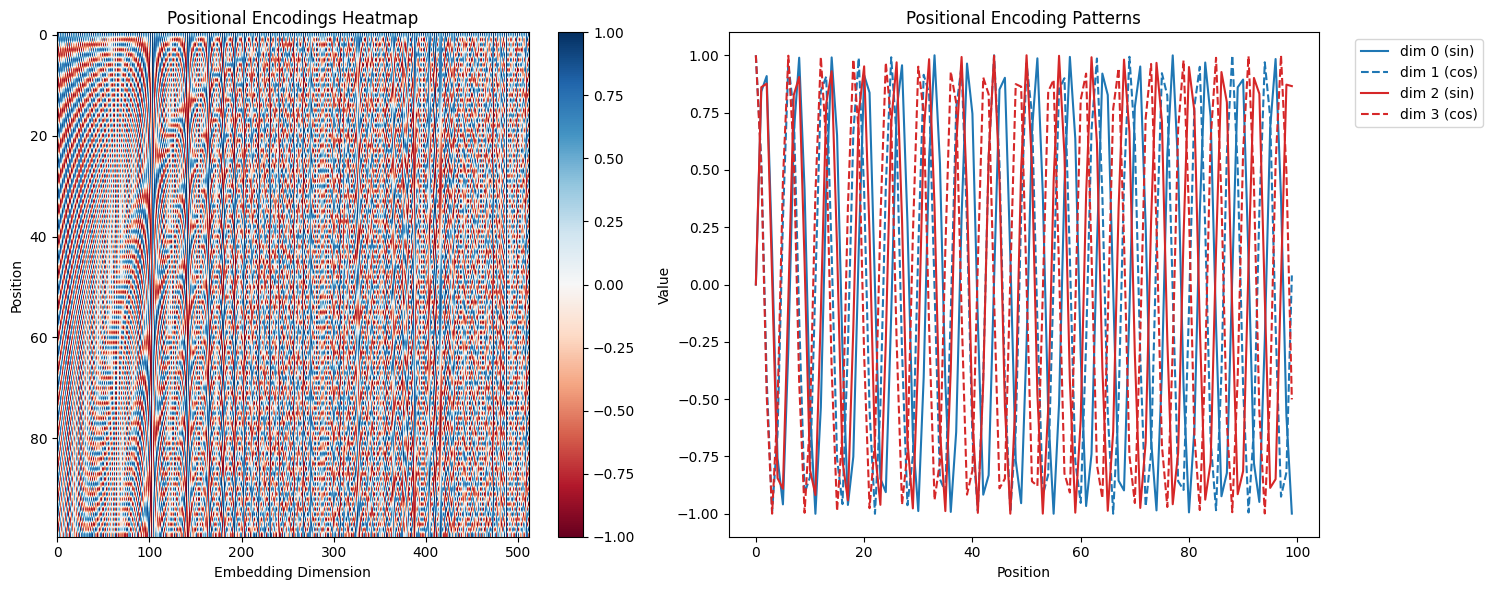

INFO:positional_encoding_debug:Starting forward pass
DEBUG:positional_encoding_debug:Input shape: (32, 95, 512)



Testing English Embeddings + Positional Encoding...
English Input Embedding Shape: (32, 95, 512)
English Output (with PE) Shape: (32, 95, 512)

Comparing FR vs EN distributions:
--------------------------------
FR Output - Mean: 0.0000, Std: 0.0164
EN Output - Mean: 0.0001, Std: 0.0156

Testing Trainable Positional Encoding:
Preparing data for positional encoding debugging...


INFO:positional_encoding_debug:Starting forward pass
DEBUG:positional_encoding_debug:Input shape: (32, 95, 512)



Testing French Embeddings + Positional Encoding...
French Input Embedding Shape: (32, 95, 512)
French Output (with PE) Shape: (32, 95, 512)

Positional Encoding Debug Summary:
-------------
Basic Statistics:
input_mean: -0.0000
input_std: 0.0151
output_mean: 0.0000
output_std: 0.0155
encoding_contribution: 0.6764

Encoding Statistics:
mean: 0.0069
std: 0.7071
max: 1.0000
min: -1.0000

Frequency Analysis:

freq_range:
  min: 0.0000
  max: 99.0000
  mean: 34.0156

Visualizing Positional Encodings...


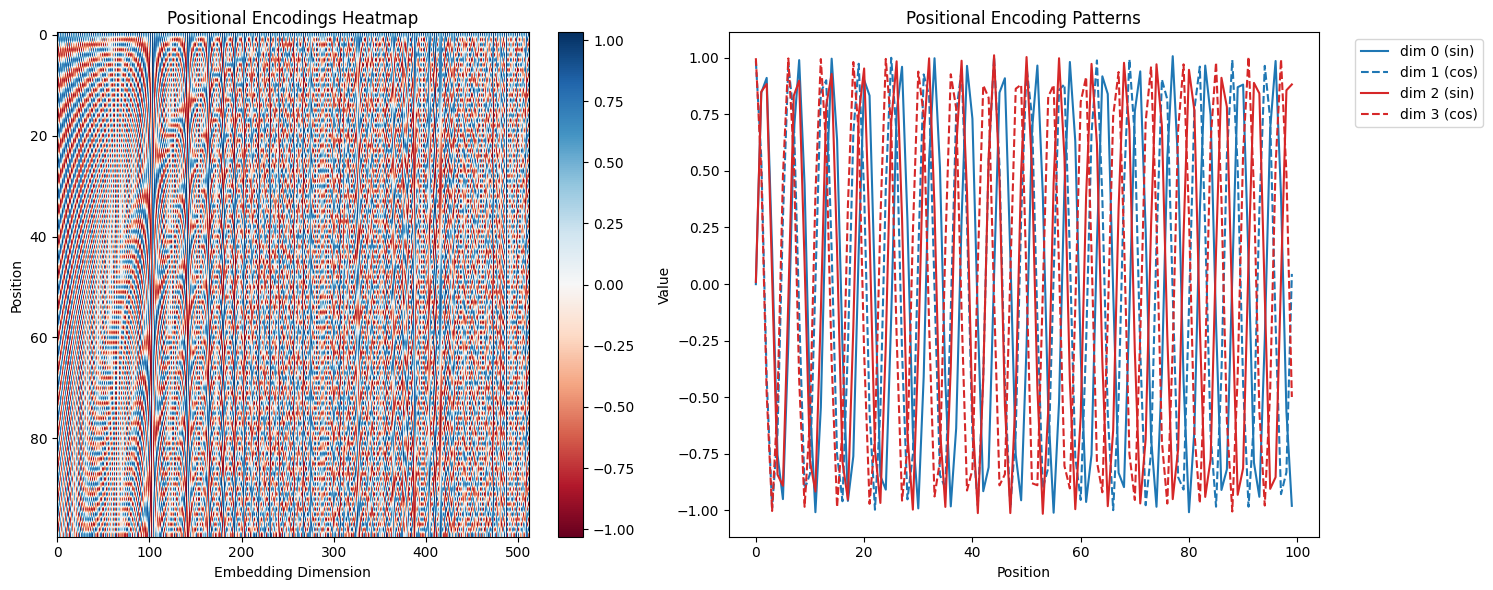

INFO:positional_encoding_debug:Starting forward pass
DEBUG:positional_encoding_debug:Input shape: (32, 95, 512)



Testing English Embeddings + Positional Encoding...
English Input Embedding Shape: (32, 95, 512)
English Output (with PE) Shape: (32, 95, 512)

Comparing FR vs EN distributions:
--------------------------------
FR Output - Mean: 0.0000, Std: 0.0155
EN Output - Mean: 0.0000, Std: 0.0146


In [4]:
class DebugPositionalEncoding(PositionalEncoding):
    def __init__(self, *args, **kwargs):
        logging.basicConfig(level=logging.DEBUG)
        self.logger = logging.getLogger("positional_encoding_debug")
        self.debug_info = {}
        
        super().__init__(*args, **kwargs)
        
    def check_numerical_stability(self, tensor: np.ndarray, name: str) -> None:
        if np.any(np.isnan(tensor)):
            self.logger.error(f"NaN values detected in {name}")
            raise ValueError(f"NaN values detected in {name}")
        if np.any(np.isinf(tensor)):
            self.logger.error(f"Inf values detected in {name}")
            raise ValueError(f"Inf values detected in {name}")
            
    def visualize_encodings(self) -> None:
        plt.figure(figsize=(15, 6))
        
        plt.subplot(1, 2, 1)
        im = plt.imshow(self.weights[0], aspect='auto', cmap='RdBu')
        plt.colorbar(im)
        plt.title('Positional Encodings Heatmap')
        plt.xlabel('Embedding Dimension')
        plt.ylabel('Position')
        
        plt.subplot(1, 2, 2)
        colors = plt.cm.tab10(np.linspace(0, 1, 4))
        for i, color in zip(range(0, min(4, self.embedding_dim), 2), colors):
            plt.plot(self.weights[0, :, i], 
                    label=f'dim {i} (sin)', 
                    linestyle='-',
                    color=color)
            plt.plot(self.weights[0, :, i+1], 
                    label=f'dim {i+1} (cos)', 
                    linestyle='--',
                    color=color)
        plt.title('Positional Encoding Patterns')
        plt.xlabel('Position')
        plt.ylabel('Value')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
        
    def analyze_frequency_components(self) -> Dict:
        analysis = {}
        
        freq_spectrum = np.abs(np.fft.fft(self.weights[0], axis=0))
        dominant_freqs = np.argmax(freq_spectrum, axis=0)
        
        analysis['freq_range'] = {
            'min': float(np.min(dominant_freqs)),
            'max': float(np.max(dominant_freqs)),
            'mean': float(np.mean(dominant_freqs))
        }
        
        if not self.trainable:
            expected_freqs = 1 / np.power(10000.0, 
                                        np.arange(0, self.embedding_dim, 2) / self.embedding_dim)
            freq_ratio = expected_freqs[:-1] / expected_freqs[1:]
            analysis['geometric_ratio'] = {
                'mean': float(np.mean(freq_ratio)),
                'std': float(np.std(freq_ratio))
            }
            
        return analysis

    def _build_sinusoidal_encoding(self) -> None:
        self.logger.info("Building sinusoidal encodings...")
        
        position = np.arange(self.max_sequence_length)[:, np.newaxis]
        self.check_numerical_stability(position, 'position')
        
        div_term = np.power(
            10000.0,
            np.arange(0, self.embedding_dim, 2, dtype=np.float32) / self.embedding_dim
        )
        self.check_numerical_stability(div_term, 'div_term')
        
        pe = np.zeros((self.max_sequence_length, self.embedding_dim), dtype=np.float32)
        
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        
        self.check_numerical_stability(pe, 'positional_encoding')
        
        self.weights = pe[np.newaxis, :, :]
        self.d_weights = np.zeros_like(self.weights)
        
        self.debug_info['div_term'] = div_term
        self.debug_info['pe_stats'] = {
            'mean': float(np.mean(pe)),
            'std': float(np.std(pe)),
            'max': float(np.max(pe)),
            'min': float(np.min(pe)),
            'wavelengths': 1 / div_term
        }
        
    def forward_pass(self, input_data: np.ndarray) -> np.ndarray:
        self.logger.info("Starting forward pass")
        batch_size, seq_len, emb_dim = input_data.shape
        self.logger.debug(f"Input shape: ({batch_size}, {seq_len}, {emb_dim})")
        
        output = super().forward_pass(input_data)
        
        self.debug_info['forward_stats'] = {
            'input_mean': float(np.mean(input_data)),
            'input_std': float(np.std(input_data)),
            'output_mean': float(np.mean(output)),
            'output_std': float(np.std(output)),
            'encoding_contribution': self.metadata['embedding_contribution']
        }
        
        return output

def debug_positional_encoding_translation(
    positional_encoding: DebugPositionalEncoding,
    dataset_path: str = "dataset.tsv",
    limit: int = 1000,
    embedding_dim: int = 512
) -> None:
    print("Preparing data for positional encoding debugging...")
    
    df = pd.read_csv(dataset_path, sep="\t")
    df.iloc[:, 1] = df.iloc[:, 1].apply(
        lambda x: re.sub(r'\\x[a-fA-F0-9]{2}|\\u[a-fA-F0-9]{4}|\xa0|\u202f', ' ', x)
    )
    
    fr_sentences = df.iloc[:, 1].values.tolist()[:limit]
    en_sentences = df.iloc[:, 3].values.tolist()[:limit]
    
    fr_tokenizer = Tokenizer(filters="")
    en_tokenizer = Tokenizer(filters="")
    
    fr_tokenizer.fit_on_texts(fr_sentences, preprocess_ponctuation=True)
    en_tokenizer.fit_on_texts(en_sentences, preprocess_ponctuation=True)
    
    X = fr_tokenizer.texts_to_sequences(fr_sentences, preprocess_ponctuation=True, add_special_tokens=True)
    y = en_tokenizer.texts_to_sequences(en_sentences, preprocess_ponctuation=True, add_special_tokens=True)
    
    max_len_x = max(len(seq) for seq in X)
    max_len_y = max(len(seq) for seq in y)
    max_seq_len = max(max_len_x, max_len_y)
    
    X = pad_sequences(X, max_length=max_seq_len, padding='post', pad_value=fr_tokenizer.PAD_IDX)
    y = pad_sequences(y, max_length=max_seq_len, padding='post', pad_value=en_tokenizer.PAD_IDX)
    
    embed_fr = Embedding(
        input_dim=len(fr_tokenizer.word_index), 
        output_dim=embedding_dim
    )
    embed_en = Embedding(
        input_dim=len(en_tokenizer.word_index), 
        output_dim=embedding_dim
    )
    
    print("\nTesting French Embeddings + Positional Encoding...")
    fr_embed = embed_fr.forward_pass(X[:32])
    fr_output = positional_encoding.forward_pass(fr_embed)
    
    print(f"French Input Embedding Shape: {fr_embed.shape}")
    print(f"French Output (with PE) Shape: {fr_output.shape}")
    
    print("\nPositional Encoding Debug Summary:")
    print("-------------")
    print("Basic Statistics:")
    for key, value in positional_encoding.debug_info['forward_stats'].items():
        print(f"{key}: {value:.4f}")
        
    print("\nEncoding Statistics:")
    for key, value in positional_encoding.debug_info['pe_stats'].items():
        if key != 'wavelengths':
            print(f"{key}: {value:.4f}")
    
    freq_analysis = positional_encoding.analyze_frequency_components()
    print("\nFrequency Analysis:")
    for category, metrics in freq_analysis.items():
        print(f"\n{category}:")
        for metric, value in metrics.items():
            print(f"  {metric}: {value:.4f}")
    
    print("\nVisualizing Positional Encodings...")
    positional_encoding.visualize_encodings()
    
    print("\nTesting English Embeddings + Positional Encoding...")
    en_embed = embed_en.forward_pass(y[:32])
    en_output = positional_encoding.forward_pass(en_embed)
    
    print(f"English Input Embedding Shape: {en_embed.shape}")
    print(f"English Output (with PE) Shape: {en_output.shape}")
    
    print("\nComparing FR vs EN distributions:")
    print("--------------------------------")
    fr_mean = np.mean(fr_output)
    fr_std = np.std(fr_output)
    en_mean = np.mean(en_output)
    en_std = np.std(en_output)
    
    print(f"FR Output - Mean: {fr_mean:.4f}, Std: {fr_std:.4f}")
    print(f"EN Output - Mean: {en_mean:.4f}, Std: {en_std:.4f}")
    
    return positional_encoding

pe_fixed = DebugPositionalEncoding(
    max_sequence_length=100,
    embedding_dim=512,
    trainable=False,
    scale_embeddings=True
)

pe_trainable = DebugPositionalEncoding(
    max_sequence_length=100,
    embedding_dim=512,
    trainable=True,
    scale_embeddings=True
)

print("\nTesting Fixed Positional Encoding:")
pe_fixed = debug_positional_encoding_translation(
    pe_fixed,
    dataset_path="dataset.tsv",
    limit=1000,
    embedding_dim=512
)

print("\nTesting Trainable Positional Encoding:")
pe_trainable = debug_positional_encoding_translation(
    pe_trainable,
    dataset_path="dataset.tsv",
    limit=1000,
    embedding_dim=512
)


Testing FeedForward Layer:
Preparing data for feedforward debugging...


INFO:feedforward_debug:Starting forward pass



Testing French Data...


DEBUG:feedforward_debug:Activation statistics: mean=0.0002, std=0.0107, sparsity=0.8826


French Input Shape: (32, 95, 512)
French Output Shape: (32, 95, 512)

Forward Pass Statistics (French):
------------------------------

input:
  mean: 0.0001
  std: 0.0151
  max: 0.1840
  min: -0.1801
  sparsity: 0.8826
  shape: (32, 95, 512)

dense1_output:
  mean: 0.0000
  std: 0.0213
  max: 0.2899
  min: -0.2658
  sparsity: 0.8826
  shape: (32, 95, 2048)

activation_output:
  mean: 0.0002
  std: 0.0107
  max: 0.1780
  min: -0.1051
  sparsity: 0.8826
  shape: (32, 95, 2048)

dropout_output:
  mean: 0.0002
  std: 0.0113
  max: 0.1978
  min: -0.1167
  sparsity: 0.8943
  shape: (32, 95, 2048)

output:
  mean: -0.0001
  std: 0.0143
  max: 0.1745
  min: -0.1891
  sparsity: 0.8826
  shape: (32, 95, 512)

Visualizing French Activations...


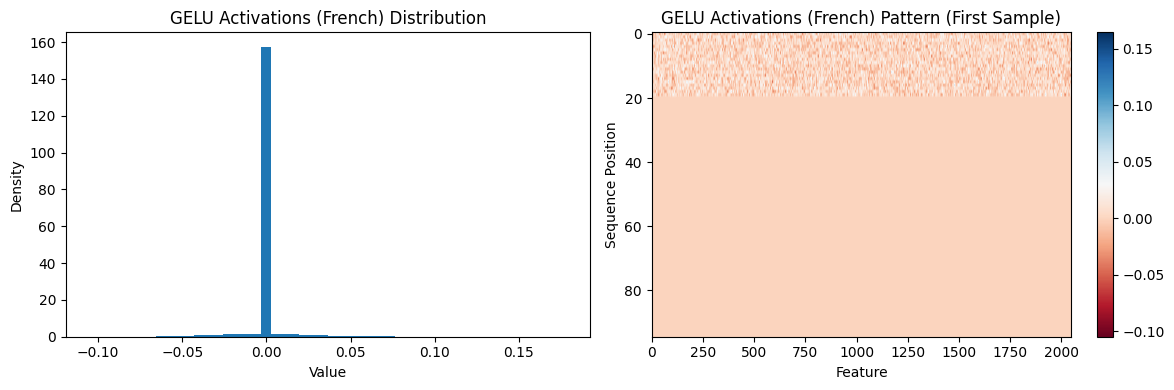

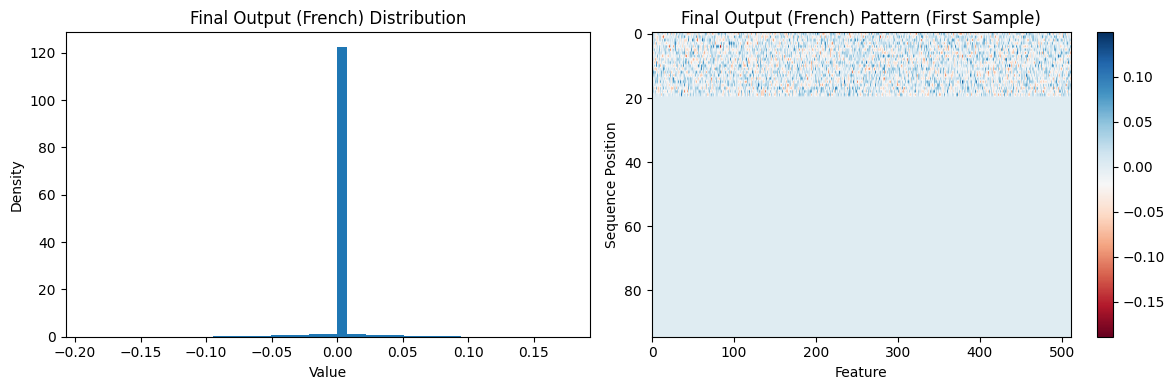

INFO:feedforward_debug:Starting backward pass



Testing Gradients (French)...


INFO:feedforward_debug:Starting forward pass



Backward Pass Statistics (French):
------------------------------

initial_gradient:
  mean: 0.0001
  std: 0.1000
  max: 0.5269
  min: -0.4954
  sparsity: 0.0000
  shape: (32, 95, 512)

dense2_gradient:
  mean: -0.0000
  std: 0.0632
  max: 0.3760
  min: -0.3313
  sparsity: 0.0000
  shape: (32, 95, 2048)

dropout_gradient:
  mean: -0.0000
  std: 0.0666
  max: 0.4178
  min: -0.3681
  sparsity: 0.0998
  shape: (32, 95, 2048)

activation_gradient:
  mean: -0.0000
  std: 0.0333
  max: 0.2089
  min: -0.1840
  sparsity: 0.0998
  shape: (32, 95, 2048)

final_gradient:
  mean: -0.0000
  std: 0.0943
  max: 0.4876
  min: -0.4800
  sparsity: 0.0000
  shape: (32, 95, 512)

Testing English Data...


DEBUG:feedforward_debug:Activation statistics: mean=0.0002, std=0.0101, sparsity=0.8957



Comparing FR vs EN distributions:
------------------------------
French Output -
  Mean: -0.0001
  Std: 0.0143
  Sparsity: 0.8826

English Output -
  Mean: -0.0000
  Std: 0.0136
  Sparsity: 0.8957


In [5]:
class DebugFeedForward(FeedForward):
    def __init__(self, *args, **kwargs):
        logging.basicConfig(level=logging.DEBUG)
        self.logger = logging.getLogger("feedforward_debug")
        self.debug_info = {}
        self.cached_tensors = {}
        
        super().__init__(*args, **kwargs)
        
    def check_numerical_stability(self, tensor: np.ndarray, name: str) -> None:
        if np.any(np.isnan(tensor)):
            self.logger.error(f"NaN values detected in {name}")
            raise ValueError(f"NaN values detected in {name}")
        if np.any(np.isinf(tensor)):
            self.logger.error(f"Inf values detected in {name}")
            raise ValueError(f"Inf values detected in {name}")
            
    def analyze_tensor(self, tensor: np.ndarray, name: str) -> Dict:
        self.cached_tensors[name] = tensor.copy()
        
        stats = {
            'mean': float(np.mean(tensor)),
            'std': float(np.std(tensor)),
            'max': float(np.max(tensor)),
            'min': float(np.min(tensor)),
            'sparsity': float(np.mean(np.abs(tensor) < 1e-6)),
            'shape': tensor.shape
        }
        self.debug_info[name] = stats
        return stats
        
    def visualize_activations(self, name: str, title: str) -> None:
        if name not in self.cached_tensors:
            self.logger.error(f"No cached tensor found for {name}")
            return
            
        tensor = self.cached_tensors[name]
        
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.hist(tensor.flatten(), bins=50, density=True)
        plt.title(f'{title} Distribution')
        plt.xlabel('Value')
        plt.ylabel('Density')
        
        plt.subplot(1, 2, 2)
        plt.imshow(tensor[0], aspect='auto', cmap='RdBu')
        plt.colorbar()
        plt.title(f'{title} Pattern (First Sample)')
        plt.xlabel('Feature')
        plt.ylabel('Sequence Position')
        
        plt.tight_layout()
        plt.show()
        
    def forward_pass(self, input_data: np.ndarray, training: bool = True) -> np.ndarray:
        self.logger.info("Starting forward pass")
        
        self.analyze_tensor(input_data, 'input')
        self.check_numerical_stability(input_data, 'input')
        
        x = self.dense1.forward_pass(input_data)
        self.analyze_tensor(x, 'dense1_output')
        self.check_numerical_stability(x, 'dense1_output')
        
        x = self.activation.forward_pass(x)
        act_stats = self.analyze_tensor(x, 'activation_output')
        self.check_numerical_stability(x, 'activation_output')
        
        self.logger.debug(f"Activation statistics: mean={act_stats['mean']:.4f}, "
                         f"std={act_stats['std']:.4f}, "
                         f"sparsity={act_stats['sparsity']:.4f}")
        
        if training:
            x = self.dropout.forward_pass(x, training=True)
            self.analyze_tensor(x, 'dropout_output')
            self.check_numerical_stability(x, 'dropout_output')
        
        x = self.dense2.forward_pass(x)
        self.analyze_tensor(x, 'output')
        self.check_numerical_stability(x, 'output')
        
        return x
        
    def backward_pass(self, output_error: np.ndarray) -> np.ndarray:
        self.logger.info("Starting backward pass")
        
        self.analyze_tensor(output_error, 'initial_gradient')
        self.check_numerical_stability(output_error, 'initial_gradient')
        
        dx = self.dense2.backward_pass(output_error)
        self.analyze_tensor(dx, 'dense2_gradient')
        self.check_numerical_stability(dx, 'dense2_gradient')
        
        dx = self.dropout.backward_pass(dx)
        self.analyze_tensor(dx, 'dropout_gradient')
        self.check_numerical_stability(dx, 'dropout_gradient')
        
        dx = self.activation.backward_pass(dx)
        self.analyze_tensor(dx, 'activation_gradient')
        self.check_numerical_stability(dx, 'activation_gradient')
        
        dx = self.dense1.backward_pass(dx)
        self.analyze_tensor(dx, 'final_gradient')
        self.check_numerical_stability(dx, 'final_gradient')
        
        return dx

def debug_feedforward_translation(
    feedforward: DebugFeedForward,
    dataset_path: str = "dataset.tsv",
    limit: int = 1000,
    embedding_dim: int = 512
) -> None:
    print("Preparing data for feedforward debugging...")
    
    df = pd.read_csv(dataset_path, sep="\t")
    df.iloc[:, 1] = df.iloc[:, 1].apply(
        lambda x: re.sub(r'\\x[a-fA-F0-9]{2}|\\u[a-fA-F0-9]{4}|\xa0|\u202f', ' ', x)
    )
    
    fr_sentences = df.iloc[:, 1].values.tolist()[:limit]
    en_sentences = df.iloc[:, 3].values.tolist()[:limit]
    
    fr_tokenizer = Tokenizer(filters="")
    en_tokenizer = Tokenizer(filters="")
    
    fr_tokenizer.fit_on_texts(fr_sentences, preprocess_ponctuation=True)
    en_tokenizer.fit_on_texts(en_sentences, preprocess_ponctuation=True)
    
    X = fr_tokenizer.texts_to_sequences(fr_sentences, preprocess_ponctuation=True, add_special_tokens=True)
    y = en_tokenizer.texts_to_sequences(en_sentences, preprocess_ponctuation=True, add_special_tokens=True)
    
    max_len_x = max(len(seq) for seq in X)
    max_len_y = max(len(seq) for seq in y)
    max_seq_len = max(max_len_x, max_len_y)
    
    X = pad_sequences(X, max_length=max_seq_len, padding='post', pad_value=fr_tokenizer.PAD_IDX)
    y = pad_sequences(y, max_length=max_seq_len, padding='post', pad_value=en_tokenizer.PAD_IDX)
    
    embed_fr = Embedding(
        input_dim=len(fr_tokenizer.word_index), 
        output_dim=embedding_dim
    )
    embed_en = Embedding(
        input_dim=len(en_tokenizer.word_index), 
        output_dim=embedding_dim
    )
    
    print("\nTesting French Data...")
    fr_embed = embed_fr.forward_pass(X[:32])
    fr_output = feedforward.forward_pass(fr_embed, training=True)
    
    print(f"French Input Shape: {fr_embed.shape}")
    print(f"French Output Shape: {fr_output.shape}")
    
    print("\nForward Pass Statistics (French):")
    print("-" * 30)
    for name, stats in feedforward.debug_info.items():
        if 'gradient' not in name:
            print(f"\n{name}:")
            for metric, value in stats.items():
                if metric != 'shape':
                    print(f"  {metric}: {value:.4f}")
                else:
                    print(f"  {metric}: {value}")
    
    print("\nVisualizing French Activations...")
    feedforward.visualize_activations('activation_output', 'GELU Activations (French)')
    feedforward.visualize_activations('output', 'Final Output (French)')
    
    print("\nTesting Gradients (French)...")
    fr_grad = np.random.normal(0, 0.1, fr_output.shape)
    fr_dx = feedforward.backward_pass(fr_grad)
    
    print("\nBackward Pass Statistics (French):")
    print("-" * 30)
    gradient_keys = [k for k in feedforward.debug_info.keys() if 'gradient' in k]
    for key in gradient_keys:
        print(f"\n{key}:")
        for metric, value in feedforward.debug_info[key].items():
            if metric != 'shape':
                print(f"  {metric}: {value:.4f}")
            else:
                print(f"  {metric}: {value}")
    
    print("\nTesting English Data...")
    en_embed = embed_en.forward_pass(y[:32])
    en_output = feedforward.forward_pass(en_embed, training=True)
    
    print("\nComparing FR vs EN distributions:")
    print("-" * 30)
    fr_stats = {
        'mean': np.mean(fr_output),
        'std': np.std(fr_output),
        'sparsity': np.mean(np.abs(fr_output) < 1e-6)
    }
    en_stats = {
        'mean': np.mean(en_output),
        'std': np.std(en_output),
        'sparsity': np.mean(np.abs(en_output) < 1e-6)
    }
    
    print("French Output -")
    print(f"  Mean: {fr_stats['mean']:.4f}")
    print(f"  Std: {fr_stats['std']:.4f}")
    print(f"  Sparsity: {fr_stats['sparsity']:.4f}")
    
    print("\nEnglish Output -")
    print(f"  Mean: {en_stats['mean']:.4f}")
    print(f"  Std: {en_stats['std']:.4f}")
    print(f"  Sparsity: {en_stats['sparsity']:.4f}")
    
    return feedforward

ff_debug = DebugFeedForward(
    d_ff=2048,
    d_model=512,
    dropout_rate=0.1,
    activation='gelu'
)

print("\nTesting FeedForward Layer:")
ff_debug = debug_feedforward_translation(
    ff_debug,
    dataset_path="dataset.tsv",
    limit=1000,
    embedding_dim=512
)


Testing AddNorm Layer:
Preparing data for AddNorm debugging...


INFO:addnorm_debug:Starting forward pass



Testing French Data...
French Input Shape: (32, 95, 512)
French Output Shape: (32, 95, 512)

Forward Pass Statistics (French):
------------------------------

main_input:
  mean: 0.0000
  std: 0.0151
  max: 0.2422
  min: -0.1793
  shape: (32, 95, 512)

residual_input:
  mean: 0.0000
  std: 0.0015
  max: 0.0242
  min: -0.0179
  shape: (32, 95, 512)

combined_input:
  mean: 0.0000
  std: 0.0167
  max: 0.2664
  min: -0.1972
  shape: (32, 95, 512)

gamma:
  mean: 1.0001
  std: 0.0500
  max: 1.1919
  min: 0.8609
  shape: (1, 1, 512)

beta:
  mean: -0.0004
  std: 0.0097
  max: 0.0318
  min: -0.0279
  shape: (1, 1, 512)

grad_ema:
  mean: 0.0000
  std: 0.0000
  max: 0.0000
  min: 0.0000
  shape: (1, 1, 512)

grad_emv:
  mean: 1.0000
  std: 0.0000
  max: 1.0000
  min: 1.0000
  shape: (1, 1, 512)

normalized:
  mean: -0.0000
  std: 0.3423
  max: 5.4682
  min: -4.0432
  shape: (32, 95, 512)
  mean_of_means: -0.0000
  mean_of_stds: 0.1173

output:
  mean: -0.0005
  std: 0.3427
  max: 5.9278
  mi

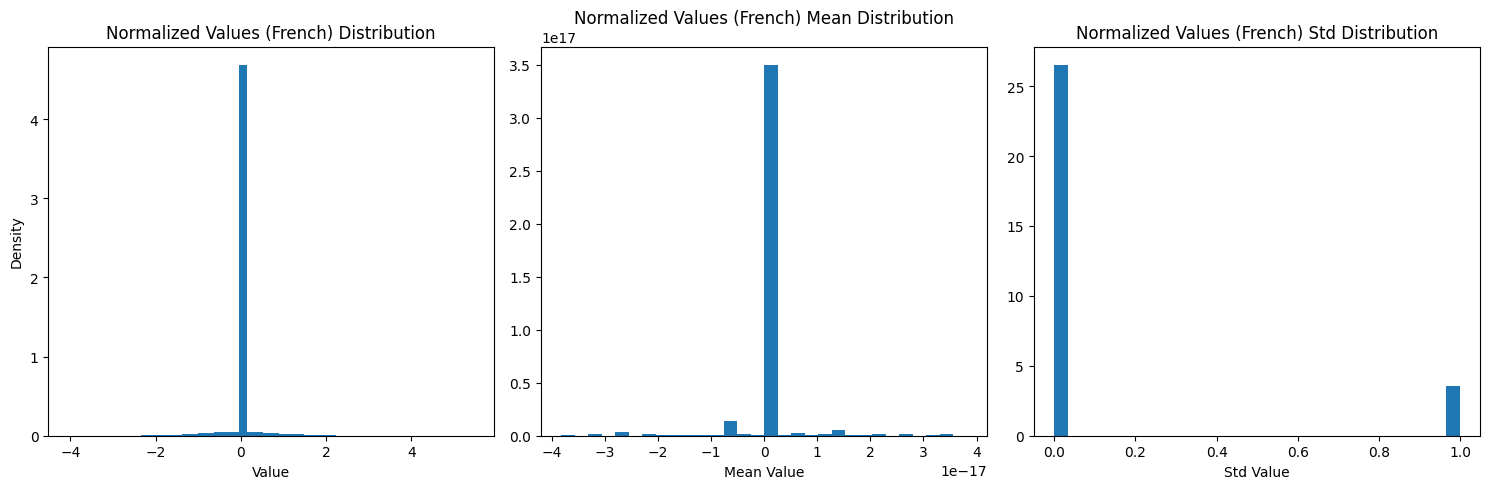

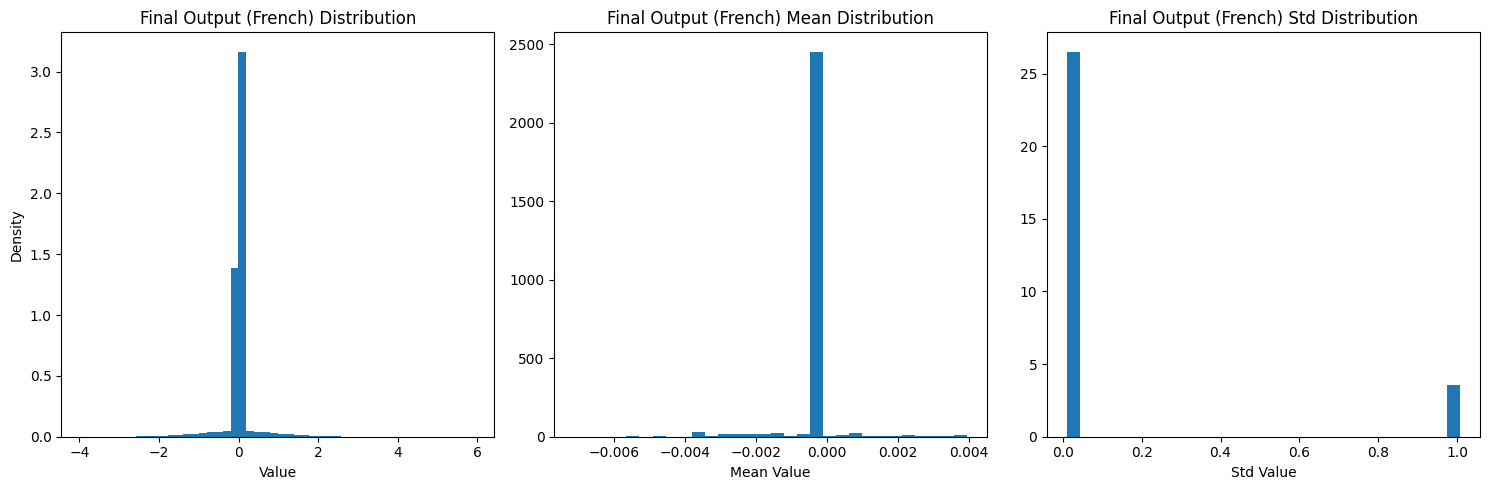

INFO:addnorm_debug:Starting backward pass
INFO:addnorm_debug:Starting forward pass
INFO:addnorm_debug:Starting forward pass



Testing Gradients (French)...

Backward Pass Statistics (French):
------------------------------

output_gradient:
  mean: 0.0001
  std: 0.1001
  max: 0.5031
  min: -0.4993
  shape: (32, 95, 512)

gamma_gradient:
  mean: 0.0000
  std: 0.0000
  max: 0.0000
  min: -0.0000
  shape: (1, 1, 512)

beta_gradient:
  mean: 0.0000
  std: 0.0000
  max: 0.0000
  min: -0.0000
  shape: (1, 1, 512)

input_gradient:
  mean: 0.0004
  std: 0.9169
  max: 1.0000
  min: -1.0000
  shape: (32, 95, 512)

Testing English Data...

Comparing FR vs EN distributions:
------------------------------
French Normalized -
  mean: 0.0000
  std: 0.3225
  mean_of_means: 0.0000
  mean_of_stds: 0.1042

French Output -
  mean: -0.0005
  std: 0.3427

English Normalized -
  mean: 0.0000
  std: 0.3225
  mean_of_means: 0.0000
  mean_of_stds: 0.1042

English Output -
  mean: -0.0004
  std: 0.3229


In [6]:
class DebugAddNorm(AddNorm):
    def __init__(self, *args, **kwargs):
        logging.basicConfig(level=logging.DEBUG)
        self.logger = logging.getLogger("addnorm_debug")
        self.debug_info = {}
        self.cached_tensors = {}
        
        super().__init__(*args, **kwargs)
        
    def check_numerical_stability(self, tensor: np.ndarray, name: str) -> None:
        if np.any(np.isnan(tensor)):
            self.logger.error(f"NaN values detected in {name}")
            raise ValueError(f"NaN values detected in {name}")
        if np.any(np.isinf(tensor)):
            self.logger.error(f"Inf values detected in {name}")
            raise ValueError(f"Inf values detected in {name}")
            
    def analyze_tensor(self, tensor: np.ndarray, name: str) -> Dict:
        self.cached_tensors[name] = tensor.copy()
        
        stats = {
            'mean': float(np.mean(tensor)),
            'std': float(np.std(tensor)),
            'max': float(np.max(tensor)),
            'min': float(np.min(tensor)),
            'shape': tensor.shape
        }
        
        if 'normalized' in name:
            stats['mean_of_means'] = float(np.mean(np.mean(tensor, axis=-1)))
            stats['mean_of_stds'] = float(np.mean(np.std(tensor, axis=-1)))
            
        self.debug_info[name] = stats
        return stats
        
    def forward_pass(self, inputs: Tuple[np.ndarray, np.ndarray]) -> np.ndarray:
        self.logger.info("Starting forward pass")
        x, residual = inputs
        self.residual = residual
        
        self.analyze_tensor(x, 'main_input')
        self.analyze_tensor(residual, 'residual_input')
        
        combined = x + residual
        self.analyze_tensor(combined, 'combined_input')
        
        if self.gamma is None:
            self.initialize_weights(combined.shape)
            self.analyze_tensor(self.gamma, 'gamma')
            self.analyze_tensor(self.beta, 'beta')
            self.analyze_tensor(self.grad_ema, 'grad_ema')
            self.analyze_tensor(self.grad_emv, 'grad_emv')
        
        self.mean = np.mean(combined, axis=-1, keepdims=True)
        self.var = np.var(combined, axis=-1, keepdims=True, ddof=1) + self.epsilon
        
        std = np.sqrt(self.var)
        self.normalized = (combined - self.mean) / std
        
        self.analyze_tensor(self.normalized, 'normalized')
        self.check_numerical_stability(self.normalized, 'normalized')
        
        self.std = std
        self.output_before_gamma = self.normalized
        
        output = self.gamma * self.normalized + self.beta
        self.analyze_tensor(output, 'output')
        self.check_numerical_stability(output, 'output')
        
        return output
        
    def backward_pass(self, output_error: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        self.logger.info("Starting backward pass")
        
        self.analyze_tensor(output_error, 'output_gradient')
        
        N = output_error.shape[-1]
        batch_size = output_error.shape[0]
        self.step += 1
        
        scaled_error = output_error * self.grad_scale
        
        d_gamma_raw = np.sum(scaled_error * self.output_before_gamma, axis=(0, 1), keepdims=True)
        d_beta_raw = np.sum(scaled_error, axis=(0, 1), keepdims=True)
        
        scale = 1.0 / (batch_size * output_error.shape[1])
        d_gamma = d_gamma_raw * scale
        d_beta = d_beta_raw * scale
        
        self.update_gradient_stats(d_gamma)
        
        self.d_gamma = self.normalize_gradients(d_gamma)
        self.d_beta = self.normalize_gradients(d_beta)
        
        self.analyze_tensor(self.d_gamma, 'gamma_gradient')
        self.analyze_tensor(self.d_beta, 'beta_gradient')
        
        d_normalized = scaled_error * self.gamma
        
        d_variance = np.clip(
            -0.5 * np.sum(d_normalized * self.output_before_gamma, axis=-1, keepdims=True) / self.std,
            -self.grad_clip, self.grad_clip
        )
        
        d_mean = np.clip(
            -np.sum(d_normalized / self.std, axis=-1, keepdims=True),
            -self.grad_clip, self.grad_clip
        )
        
        d_input = np.clip(
            (d_normalized / self.std + 
             2.0 * d_variance * self.output_before_gamma / N +
             d_mean / N),
            -self.grad_clip, self.grad_clip
        )
                  
        self.analyze_tensor(d_input, 'input_gradient')
        self.check_numerical_stability(d_input, 'input_gradient')
        
        return d_input, d_input

    def visualize_distribution(self, name: str, title: str) -> None:
        if name not in self.cached_tensors:
            self.logger.error(f"No cached tensor found for {name}")
            return
            
        tensor = self.cached_tensors[name]
        
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.hist(tensor.flatten(), bins=50, density=True)
        plt.title(f'{title} Distribution')
        plt.xlabel('Value')
        plt.ylabel('Density')
        
        plt.subplot(1, 3, 2)
        means = np.mean(tensor, axis=-1)
        plt.hist(means.flatten(), bins=30, density=True)
        plt.title(f'{title} Mean Distribution')
        plt.xlabel('Mean Value')
        
        plt.subplot(1, 3, 3)
        stds = np.std(tensor, axis=-1)
        plt.hist(stds.flatten(), bins=30, density=True)
        plt.title(f'{title} Std Distribution')
        plt.xlabel('Std Value')
        
        plt.tight_layout()
        plt.show()

def debug_addnorm_translation(
    add_norm: DebugAddNorm,
    dataset_path: str = "dataset.tsv",
    limit: int = 1000,
    embedding_dim: int = 512
) -> None:
    print("Preparing data for AddNorm debugging...")
    
    df = pd.read_csv(dataset_path, sep="\t")
    df.iloc[:, 1] = df.iloc[:, 1].apply(
        lambda x: re.sub(r'\\x[a-fA-F0-9]{2}|\\u[a-fA-F0-9]{4}|\xa0|\u202f', ' ', x)
    )
    
    fr_sentences = df.iloc[:, 1].values.tolist()[:limit]
    en_sentences = df.iloc[:, 3].values.tolist()[:limit]
    
    fr_tokenizer = Tokenizer(filters="")
    en_tokenizer = Tokenizer(filters="")
    
    fr_tokenizer.fit_on_texts(fr_sentences, preprocess_ponctuation=True)
    en_tokenizer.fit_on_texts(en_sentences, preprocess_ponctuation=True)
    
    X = fr_tokenizer.texts_to_sequences(fr_sentences, preprocess_ponctuation=True, add_special_tokens=True)
    y = en_tokenizer.texts_to_sequences(en_sentences, preprocess_ponctuation=True, add_special_tokens=True)
    
    max_len_x = max(len(seq) for seq in X)
    max_len_y = max(len(seq) for seq in y)
    max_seq_len = max(max_len_x, max_len_y)
    
    X = pad_sequences(X, max_length=max_seq_len, padding='post', pad_value=fr_tokenizer.PAD_IDX)
    y = pad_sequences(y, max_length=max_seq_len, padding='post', pad_value=en_tokenizer.PAD_IDX)
    
    embed_fr = Embedding(
        input_dim=len(fr_tokenizer.word_index), 
        output_dim=embedding_dim
    )
    embed_en = Embedding(
        input_dim=len(en_tokenizer.word_index), 
        output_dim=embedding_dim
    )
    
    print("\nTesting French Data...")
    fr_embed = embed_fr.forward_pass(X[:32])
    
    fr_residual = fr_embed * 0.1
    
    fr_output = add_norm.forward_pass((fr_embed, fr_residual))
    
    print(f"French Input Shape: {fr_embed.shape}")
    print(f"French Output Shape: {fr_output.shape}")
    
    print("\nForward Pass Statistics (French):")
    print("-" * 30)
    forward_keys = [k for k in add_norm.debug_info.keys() if 'gradient' not in k]
    for name in forward_keys:
        print(f"\n{name}:")
        for metric, value in add_norm.debug_info[name].items():
            if isinstance(value, (int, float)):
                print(f"  {metric}: {value:.4f}")
            else:
                print(f"  {metric}: {value}")
    
    print("\nVisualizing French Distributions...")
    add_norm.visualize_distribution('normalized', 'Normalized Values (French)')
    add_norm.visualize_distribution('output', 'Final Output (French)')
    
    print("\nTesting Gradients (French)...")
    fr_grad = np.random.normal(0, 0.1, fr_output.shape)
    fr_dx, fr_dr = add_norm.backward_pass(fr_grad)
    
    print("\nBackward Pass Statistics (French):")
    print("-" * 30)
    gradient_keys = [k for k in add_norm.debug_info.keys() if 'gradient' in k]
    for key in gradient_keys:
        print(f"\n{key}:")
        for metric, value in add_norm.debug_info[key].items():
            if isinstance(value, (int, float)):
                print(f"  {metric}: {value:.4f}")
            else:
                print(f"  {metric}: {value}")
    
    print("\nTesting English Data...")
    en_embed = embed_en.forward_pass(y[:32])
    en_residual = en_embed * 0.1
    en_output = add_norm.forward_pass((en_embed, en_residual))
    
    print("\nComparing FR vs EN distributions:")
    print("-" * 30)
    
    fr_norm_stats = {
        'mean': np.mean(add_norm.normalized),
        'std': np.std(add_norm.normalized),
        'mean_of_means': np.mean(np.mean(add_norm.normalized, axis=-1)),
        'mean_of_stds': np.mean(np.std(add_norm.normalized, axis=-1))
    }
    
    fr_output_stats = {
        'mean': np.mean(fr_output),
        'std': np.std(fr_output)
    }
    
    en_output = add_norm.forward_pass((en_embed, en_residual))
    
    en_norm_stats = {
        'mean': np.mean(add_norm.normalized),
        'std': np.std(add_norm.normalized),
        'mean_of_means': np.mean(np.mean(add_norm.normalized, axis=-1)),
        'mean_of_stds': np.mean(np.std(add_norm.normalized, axis=-1))
    }
    
    en_output_stats = {
        'mean': np.mean(en_output),
        'std': np.std(en_output)
    }
    
    print("French Normalized -")
    for metric, value in fr_norm_stats.items():
        print(f"  {metric}: {value:.4f}")
    
    print("\nFrench Output -")
    for metric, value in fr_output_stats.items():
        print(f"  {metric}: {value:.4f}")
    
    print("\nEnglish Normalized -")
    for metric, value in en_norm_stats.items():
        print(f"  {metric}: {value:.4f}")
    
    print("\nEnglish Output -")
    for metric, value in en_output_stats.items():
        print(f"  {metric}: {value:.4f}")
    
    return add_norm

add_norm_debug = DebugAddNorm(epsilon=1e-6)

print("\nTesting AddNorm Layer:")
add_norm_debug = debug_addnorm_translation(
    add_norm_debug,
    dataset_path="dataset.tsv",
    limit=1000,
    embedding_dim=512
)


Testing Transformer Layer:
Preparing data for transformer layer debugging...


INFO:transformer_debug:Starting forward pass



Testing French Data...
French Input Shape: (32, 95, 512)
French Output Shape: (32, 95, 512)

Forward Pass Statistics (French):
------------------------------

input:
  mean: 0.0000
  std: 0.0151
  max: 0.2065
  min: -0.2073
  shape: (32, 95, 512)

attention_output:
  mean: 0.0013
  std: 0.0148
  max: 0.0733
  min: -0.0605
  shape: (32, 95, 512)

attention_dropout:
  mean: 0.0013
  std: 0.0156
  max: 0.0815
  min: -0.0672
  shape: (32, 95, 512)

attention_residual:
  main_norm: 0.0117
  residual_norm: 0.0041
  ratio: 0.3554

attention_norm:
  mean: 0.0004
  std: 0.9984
  max: 4.8355
  min: -4.6916
  shape: (32, 95, 512)

ffn_output:
  mean: 0.0039
  std: 0.5194
  max: 2.3651
  min: -2.4267
  shape: (32, 95, 512)

ffn_dropout:
  mean: 0.0041
  std: 0.5476
  max: 2.6279
  min: -2.6964
  shape: (32, 95, 512)

ffn_residual:
  main_norm: 0.4140
  residual_norm: 0.7644
  ratio: 1.8462

final_output:
  mean: 0.0004
  std: 0.9974
  max: 4.4715
  min: -4.6205
  shape: (32, 95, 512)

Visualizing

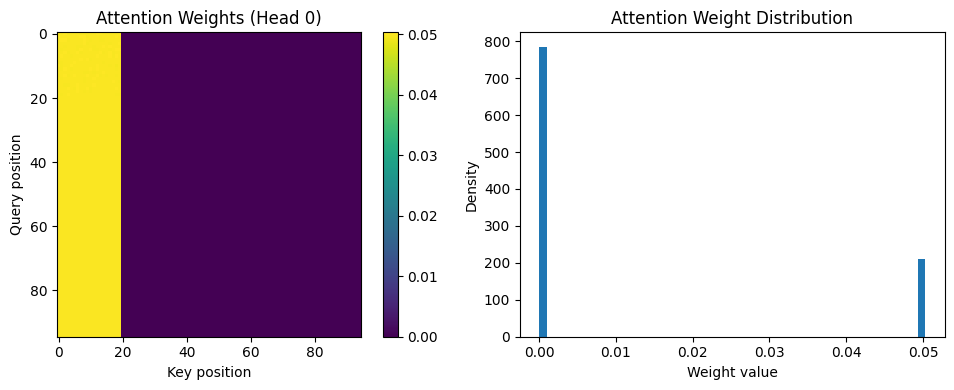

INFO:transformer_debug:Starting backward pass



Testing Gradients (French)...


INFO:transformer_debug:Starting forward pass



Backward Pass Statistics (French):
------------------------------

initial_gradient:
  mean: -0.0001
  std: 0.1000
  max: 0.5190
  min: -0.5500
  shape: (32, 95, 512)

ffn_norm_gradient:
  mean: -0.0000
  std: 0.0087
  max: 0.0457
  min: -0.0485
  shape: (32, 95, 512)

ffn_norm_residual_gradient:
  mean: -0.0000
  std: 0.0087
  max: 0.0457
  min: -0.0485
  shape: (32, 95, 512)

combined_ffn_gradient:
  mean: 0.0000
  std: 0.0099
  max: 0.0492
  min: -0.0487
  shape: (32, 95, 512)

attention_norm_gradient:
  mean: 0.0000
  std: 0.0628
  max: 0.4911
  min: -0.3839
  shape: (32, 95, 512)

attention_norm_residual_gradient:
  mean: 0.0000
  std: 0.0628
  max: 0.4911
  min: -0.3839
  shape: (32, 95, 512)

final_gradient:
  mean: 0.0000
  std: 0.0629
  max: 0.4911
  min: -0.3828
  shape: (32, 95, 512)

Testing English Data...


INFO:transformer_debug:Starting forward pass



Comparing FR vs EN distributions:
------------------------------
French Statistics:
  input_mean: 0.0000
  input_std: 0.0151
  output_mean: 0.0004
  output_std: 0.9974
  attention_ratio: 0.2978
  ffn_ratio: 1.8700

English Statistics:
  input_mean: 0.0000
  input_std: 0.0143
  output_mean: 0.0004
  output_std: 0.9976
  attention_ratio: 0.2978
  ffn_ratio: 1.8705


In [7]:
class DebugTransformerEncoderLayer(TransformerEncoderLayer):
    def __init__(self, *args, **kwargs):
        logging.basicConfig(level=logging.DEBUG)
        self.logger = logging.getLogger("transformer_debug")
        self.debug_info = {}
        super().__init__(*args, **kwargs)

    def check_numerical_stability(self, tensor: np.ndarray, name: str) -> None:
        if np.any(np.isnan(tensor)):
            self.logger.error(f"NaN values detected in {name}")
            raise ValueError(f"NaN values detected in {name}")
        if np.any(np.isinf(tensor)):
            self.logger.error(f"Inf values detected in {name}")
            raise ValueError(f"Inf values detected in {name}")

    def visualize_attention(self, head_idx: int = 0) -> None:
        if not hasattr(self.attention, 'attention_weights'):
            self.logger.warning("No attention weights available")
            return
            
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        
        weights = self.attention.attention_weights[0, head_idx]
        plt.imshow(weights, cmap='viridis')
        plt.colorbar()
        plt.title(f'Attention Weights (Head {head_idx})')
        plt.xlabel('Key position')
        plt.ylabel('Query position')
        
        plt.subplot(1, 2, 2)
        plt.hist(weights.flatten(), bins=50, density=True)
        plt.title('Attention Weight Distribution')
        plt.xlabel('Weight value')
        plt.ylabel('Density')
        
        plt.tight_layout()
        plt.show()

    def analyze_tensor(self, tensor: np.ndarray, name: str) -> dict:
        stats = {
            'mean': float(np.mean(tensor)),
            'std': float(np.std(tensor)),
            'max': float(np.max(tensor)),
            'min': float(np.min(tensor)),
            'shape': tensor.shape
        }
        self.debug_info[name] = stats
        return stats

    def analyze_residual(self, main: np.ndarray, residual: np.ndarray, name: str) -> dict:
        main_norm = np.mean(np.abs(main))
        residual_norm = np.mean(np.abs(residual))
        ratio = residual_norm / (main_norm + 1e-8)

        stats = {
            'main_norm': float(main_norm),
            'residual_norm': float(residual_norm),
            'ratio': float(ratio)
        }
        self.debug_info[f'{name}_residual'] = stats
        return stats

    def forward_pass(self, inputs: np.ndarray, mask: np.ndarray = None, training: bool = True) -> np.ndarray:
        self.logger.info("Starting forward pass")
        
        self.x = inputs
        
        self.analyze_tensor(self.x, 'input')
        self.check_numerical_stability(self.x, 'input')

        attn_output = self.attention.forward_pass(self.x, mask=mask, training=training)
        self.analyze_tensor(attn_output, 'attention_output')
        self.check_numerical_stability(attn_output, 'attention_output')

        if training:
            attn_output = self.attention_dropout.forward_pass(attn_output, training=True)
            self.analyze_tensor(attn_output, 'attention_dropout')

        self.analyze_residual(attn_output, self.x, 'attention')
        attn_output = self.attention_norm.forward_pass((attn_output, self.x))
        self.analyze_tensor(attn_output, 'attention_norm')

        ffn_output = self.ffn.forward_pass(attn_output, training=training)
        self.analyze_tensor(ffn_output, 'ffn_output')
        self.check_numerical_stability(ffn_output, 'ffn_output')

        if training:
            ffn_output = self.ffn_dropout.forward_pass(ffn_output, training=True)
            self.analyze_tensor(ffn_output, 'ffn_dropout')

        self.analyze_residual(ffn_output, attn_output, 'ffn')
        output = self.ffn_norm.forward_pass((ffn_output, attn_output))
        self.analyze_tensor(output, 'final_output')

        return output

    def backward_pass(self, output_error: np.ndarray) -> np.ndarray:
        self.logger.info("Starting backward pass")
        self.analyze_tensor(output_error, 'initial_gradient')

        ffn_norm_dx, ffn_norm_dresidual = self.ffn_norm.backward_pass(output_error)
        self.analyze_tensor(ffn_norm_dx, 'ffn_norm_gradient')
        self.analyze_tensor(ffn_norm_dresidual, 'ffn_norm_residual_gradient')

        ffn_dx = self.ffn_dropout.backward_pass(ffn_norm_dx)
        ffn_dx = self.ffn.backward_pass(ffn_dx)
        ffn_dx = ffn_dx + ffn_norm_dresidual
        self.analyze_tensor(ffn_dx, 'combined_ffn_gradient')

        attn_norm_dx, attn_norm_dresidual = self.attention_norm.backward_pass(ffn_dx)
        self.analyze_tensor(attn_norm_dx, 'attention_norm_gradient')
        self.analyze_tensor(attn_norm_dresidual, 'attention_norm_residual_gradient')

        attn_dx = self.attention_dropout.backward_pass(attn_norm_dx)
        attn_dx = self.attention.backward_pass(attn_dx)
        dx = attn_dx + attn_norm_dresidual
        self.analyze_tensor(dx, 'final_gradient')

        return dx

def debug_transformer_translation(
    transformer_layer: DebugTransformerEncoderLayer,
    dataset_path: str = "dataset.tsv",
    limit: int = 1000,
    embedding_dim: int = 512
) -> None:
    print("Preparing data for transformer layer debugging...")
    
    df = pd.read_csv(dataset_path, sep="\t")
    df.iloc[:, 1] = df.iloc[:, 1].apply(
        lambda x: re.sub(r'\\x[a-fA-F0-9]{2}|\\u[a-fA-F0-9]{4}|\xa0|\u202f', ' ', x)
    )
    
    fr_sentences = df.iloc[:, 1].values.tolist()[:limit]
    en_sentences = df.iloc[:, 3].values.tolist()[:limit]
    
    fr_tokenizer = Tokenizer(filters="")
    en_tokenizer = Tokenizer(filters="")
    
    fr_tokenizer.fit_on_texts(fr_sentences, preprocess_ponctuation=True)
    en_tokenizer.fit_on_texts(en_sentences, preprocess_ponctuation=True)
    
    X = fr_tokenizer.texts_to_sequences(fr_sentences, preprocess_ponctuation=True, add_special_tokens=True)
    y = en_tokenizer.texts_to_sequences(en_sentences, preprocess_ponctuation=True, add_special_tokens=True)
    
    max_len_x = max(len(seq) for seq in X)
    max_len_y = max(len(seq) for seq in y)
    max_seq_len = max(max_len_x, max_len_y)
    
    X = pad_sequences(X, max_length=max_seq_len, padding='post', pad_value=fr_tokenizer.PAD_IDX)
    y = pad_sequences(y, max_length=max_seq_len, padding='post', pad_value=en_tokenizer.PAD_IDX)
    
    embed_fr = Embedding(
        input_dim=len(fr_tokenizer.word_index), 
        output_dim=embedding_dim
    )
    embed_en = Embedding(
        input_dim=len(en_tokenizer.word_index), 
        output_dim=embedding_dim
    )
    
    fr_mask = (X[:32] == fr_tokenizer.PAD_IDX)
    fr_mask = fr_mask[:, np.newaxis, np.newaxis, :]
    fr_mask = np.tile(fr_mask, (1, transformer_layer.num_heads, max_seq_len, 1))
    
    print("\nTesting French Data...")
    fr_embed = embed_fr.forward_pass(X[:32])
    fr_output = transformer_layer.forward_pass(fr_embed, mask=fr_mask, training=True)
    
    print(f"French Input Shape: {fr_embed.shape}")
    print(f"French Output Shape: {fr_output.shape}")
    
    print("\nForward Pass Statistics (French):")
    print("-" * 30)
    forward_keys = [k for k in transformer_layer.debug_info.keys() if 'gradient' not in k]
    for name in forward_keys:
        print(f"\n{name}:")
        for metric, value in transformer_layer.debug_info[name].items():
            if isinstance(value, (int, float)):
                print(f"  {metric}: {value:.4f}")
            else:
                print(f"  {metric}: {value}")
    
    print("\nVisualizing French Attention Patterns...")
    transformer_layer.visualize_attention(head_idx=0)
    
    print("\nTesting Gradients (French)...")
    fr_grad = np.random.normal(0, 0.1, fr_output.shape)
    fr_dx = transformer_layer.backward_pass(fr_grad)
    
    print("\nBackward Pass Statistics (French):")
    print("-" * 30)
    gradient_keys = [k for k in transformer_layer.debug_info.keys() if 'gradient' in k]
    for key in gradient_keys:
        print(f"\n{key}:")
        for metric, value in transformer_layer.debug_info[key].items():
            if isinstance(value, (int, float)):
                print(f"  {metric}: {value:.4f}")
            else:
                print(f"  {metric}: {value}")
    
    print("\nTesting English Data...")
    en_mask = (y[:32] == en_tokenizer.PAD_IDX)
    en_mask = en_mask[:, np.newaxis, np.newaxis, :]
    en_mask = np.tile(en_mask, (1, transformer_layer.num_heads, max_seq_len, 1))
    
    en_embed = embed_en.forward_pass(y[:32])
    en_output = transformer_layer.forward_pass(en_embed, mask=en_mask, training=True)
    
    print("\nComparing FR vs EN distributions:")
    print("-" * 30)
    
    fr_stats = {
        'input_mean': np.mean(fr_embed),
        'input_std': np.std(fr_embed),
        'output_mean': np.mean(fr_output),
        'output_std': np.std(fr_output),
        'attention_ratio': transformer_layer.debug_info['attention_residual']['ratio'],
        'ffn_ratio': transformer_layer.debug_info['ffn_residual']['ratio']
    }
    
    en_output = transformer_layer.forward_pass(en_embed, mask=en_mask, training=True)
    
    en_stats = {
        'input_mean': np.mean(en_embed),
        'input_std': np.std(en_embed),
        'output_mean': np.mean(en_output),
        'output_std': np.std(en_output),
        'attention_ratio': transformer_layer.debug_info['attention_residual']['ratio'],
        'ffn_ratio': transformer_layer.debug_info['ffn_residual']['ratio']
    }
    
    print("French Statistics:")
    for metric, value in fr_stats.items():
        print(f"  {metric}: {value:.4f}")
    
    print("\nEnglish Statistics:")
    for metric, value in en_stats.items():
        print(f"  {metric}: {value:.4f}")
    
    return transformer_layer

transformer_debug = DebugTransformerEncoderLayer(
    d_model=512,
    num_heads=8,
    d_ff=2048,
    dropout_rate=0.1,
    attention_dropout=0.1,
    activation='gelu'
)

print("\nTesting Transformer Layer:")
transformer_debug = debug_transformer_translation(
    transformer_debug,
    dataset_path="dataset.tsv",
    limit=1000,
    embedding_dim=512
)


Testing Decoder Layer:
Preparing data for decoder layer debugging...


INFO:transformer_decoder_debug:Starting decoder forward pass



Testing with French-English Translation Data...
Encoder Output Shape: (32, 95, 512)
Decoder Input Shape: (32, 95, 512)
Decoder Output Shape: (32, 95, 512)

Forward Pass Statistics:
------------------------------

decoder_input:
  mean: 0.0000
  std: 0.0143
  max: 0.1750
  min: -0.1683
  shape: (32, 95, 512)

encoder_output:
  mean: -0.0000
  std: 0.0151
  max: 0.2638
  min: -0.1754
  shape: (32, 95, 512)

self_attention_output:
  mean: -0.0008
  std: 0.0168
  max: 0.1302
  min: -0.1159
  shape: (32, 95, 512)

self_attention_heads:
  head_0: {'entropy': 2.1354992821745307, 'sparsity': 0.9447229916897507, 'mean_attention': 0.010526315789473684, 'max_attention': 1.0}
  head_1: {'entropy': 2.135499288423142, 'sparsity': 0.944702216066482, 'mean_attention': 0.010526315789473684, 'max_attention': 1.0}
  head_2: {'entropy': 2.135499281335073, 'sparsity': 0.9447437673130193, 'mean_attention': 0.010526315789473684, 'max_attention': 1.0}
  head_3: {'entropy': 2.135499292944039, 'sparsity': 0.94

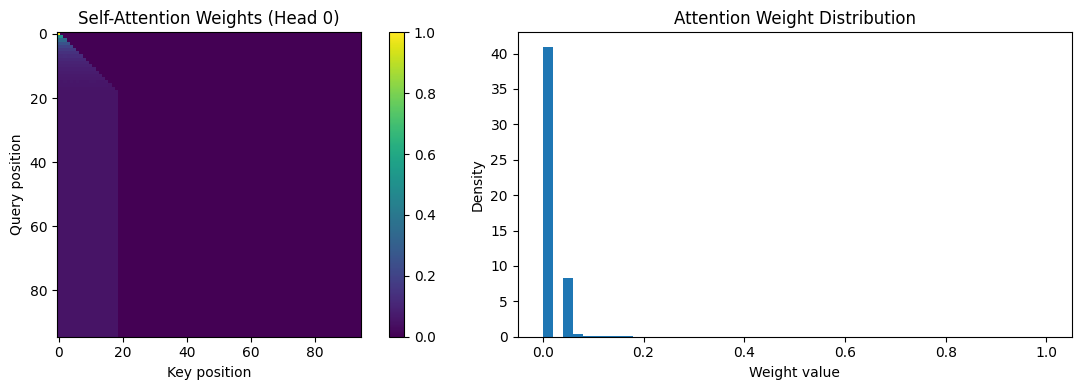


Cross-Attention Pattern (Encoder-Decoder):


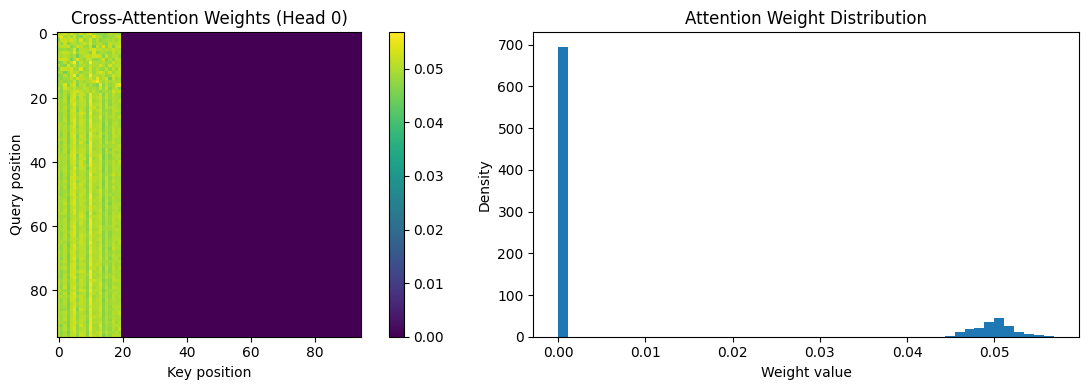

INFO:transformer_decoder_debug:Starting decoder backward pass



Testing Gradients...

Backward Pass Statistics:
------------------------------

initial_gradient:
  mean: 0.0001
  std: 0.1001
  max: 0.4777
  min: -0.5094
  shape: (32, 95, 512)

ffn_norm_gradient:
  mean: 0.0000
  std: 0.0088
  max: 0.0411
  min: -0.0491
  shape: (32, 95, 512)

ffn_norm_residual_gradient:
  mean: 0.0000
  std: 0.0088
  max: 0.0411
  min: -0.0491
  shape: (32, 95, 512)

combined_ffn_gradient:
  mean: 0.0000
  std: 0.0101
  max: 0.0488
  min: -0.0511
  shape: (32, 95, 512)

cross_attention_norm_gradient:
  mean: 0.0000
  std: 0.0010
  max: 0.0050
  min: -0.0052
  shape: (32, 95, 512)

cross_attention_norm_residual_gradient:
  mean: 0.0000
  std: 0.0010
  max: 0.0050
  min: -0.0052
  shape: (32, 95, 512)

cross_attention_query_gradient:
  mean: -0.0000
  std: 0.0008
  max: 0.0049
  min: -0.0047
  shape: (32, 95, 512)

cross_attention_key_gradient:
  mean: 0.0000
  std: 0.0008
  max: 0.0182
  min: -0.0148
  shape: (32, 95, 512)

cross_attention_value_gradient:
  mean: 0

In [8]:
class DebugTransformerDecoderLayer(TransformerDecoderLayer):
    def __init__(self, *args, **kwargs):
        logging.basicConfig(level=logging.DEBUG)
        self.logger = logging.getLogger("transformer_decoder_debug")
        self.debug_info = {}
        super().__init__(*args, **kwargs)

    def check_numerical_stability(self, tensor: np.ndarray, name: str) -> None:
        if np.any(np.isnan(tensor)):
            self.logger.error(f"NaN values detected in {name}")
            raise ValueError(f"NaN values detected in {name}")
        if np.any(np.isinf(tensor)):
            self.logger.error(f"Inf values detected in {name}")
            raise ValueError(f"Inf values detected in {name}")

    def visualize_attention(self, attention_type: str = "self", head_idx: int = 0) -> None:
        attention = self.self_attention if attention_type == "self" else self.cross_attention
        
        if not hasattr(attention, 'attention_weights'):
            self.logger.warning(f"No {attention_type}-attention weights available")
            return
            
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        
        weights = attention.attention_weights[0, head_idx]
        plt.imshow(weights, cmap='viridis')
        plt.colorbar()
        plt.title(f'{attention_type.capitalize()}-Attention Weights (Head {head_idx})')
        plt.xlabel('Key position')
        plt.ylabel('Query position')
        
        plt.subplot(1, 2, 2)
        plt.hist(weights.flatten(), bins=50, density=True)
        plt.title('Attention Weight Distribution')
        plt.xlabel('Weight value')
        plt.ylabel('Density')
        
        plt.tight_layout()
        plt.show()

    def analyze_tensor(self, tensor: np.ndarray, name: str) -> dict:
        stats = {
            'mean': float(np.mean(tensor)),
            'std': float(np.std(tensor)),
            'max': float(np.max(tensor)),
            'min': float(np.min(tensor)),
            'shape': tensor.shape
        }
        self.debug_info[name] = stats
        return stats

    def analyze_residual(self, main: np.ndarray, residual: np.ndarray, name: str) -> dict:
        main_norm = np.mean(np.abs(main))
        residual_norm = np.mean(np.abs(residual))
        ratio = residual_norm / (main_norm + 1e-8)

        stats = {
            'main_norm': float(main_norm),
            'residual_norm': float(residual_norm),
            'ratio': float(ratio)
        }
        self.debug_info[f'{name}_residual'] = stats
        return stats

    def analyze_attention_heads(self, attention_type: str) -> dict:
        attention = self.self_attention if attention_type == "self" else self.cross_attention
        if not hasattr(attention, 'attention_weights'):
            return {}

        weights = attention.attention_weights
        head_stats = {}
        
        for head in range(self.num_heads):
            head_weights = weights[:, head]
            entropy = -np.sum(head_weights * np.log(head_weights + 1e-10), axis=-1).mean()
            sparsity = np.mean((head_weights < 0.1).astype(float))
            
            head_stats[f'head_{head}'] = {
                'entropy': float(entropy),
                'sparsity': float(sparsity),
                'mean_attention': float(np.mean(head_weights)),
                'max_attention': float(np.max(head_weights))
            }
            
        self.debug_info[f'{attention_type}_attention_heads'] = head_stats
        return head_stats

    def forward_pass(self, x: np.ndarray, enc_output: np.ndarray, 
                    training: bool = True, 
                    self_attention_mask: np.ndarray = None,
                    cross_attention_mask: np.ndarray = None) -> np.ndarray:
        self.logger.info("Starting decoder forward pass")
        
        self.analyze_tensor(x, 'decoder_input')
        self.analyze_tensor(enc_output, 'encoder_output')
        self.check_numerical_stability(x, 'decoder_input')
        self.check_numerical_stability(enc_output, 'encoder_output')

        attn1 = self.self_attention.forward_pass(x, mask=self_attention_mask, training=training)
        self.analyze_tensor(attn1, 'self_attention_output')
        self.check_numerical_stability(attn1, 'self_attention_output')
        self.analyze_attention_heads('self')

        if training:
            attn1 = self.dropout1.forward_pass(attn1, training=True)
            self.analyze_tensor(attn1, 'self_attention_dropout')

        self.analyze_residual(attn1, x, 'self_attention')
        out1 = self.norm1.forward_pass((attn1, x))
        self.analyze_tensor(out1, 'self_attention_norm')

        attn2 = self.cross_attention.forward_pass(
            (out1, enc_output, enc_output),
            mask=cross_attention_mask,
            training=training
        )
        self.analyze_tensor(attn2, 'cross_attention_output')
        self.check_numerical_stability(attn2, 'cross_attention_output')
        self.analyze_attention_heads('cross')

        if training:
            attn2 = self.dropout2.forward_pass(attn2, training=True)
            self.analyze_tensor(attn2, 'cross_attention_dropout')

        self.analyze_residual(attn2, out1, 'cross_attention')
        out2 = self.norm2.forward_pass((attn2, out1))
        self.analyze_tensor(out2, 'cross_attention_norm')

        ffn_out = self.ffn.forward_pass(out2, training=training)
        self.analyze_tensor(ffn_out, 'ffn_output')
        self.check_numerical_stability(ffn_out, 'ffn_output')

        if training:
            ffn_out = self.dropout3.forward_pass(ffn_out, training=True)
            self.analyze_tensor(ffn_out, 'ffn_dropout')

        self.analyze_residual(ffn_out, out2, 'ffn')
        out3 = self.norm3.forward_pass((ffn_out, out2))
        self.analyze_tensor(out3, 'final_output')

        return out3

    def backward_pass(self, output_error: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        self.logger.info("Starting decoder backward pass")
        self.analyze_tensor(output_error, 'initial_gradient')

        d_norm3, d_residual3 = self.norm3.backward_pass(output_error)
        self.analyze_tensor(d_norm3, 'ffn_norm_gradient')
        self.analyze_tensor(d_residual3, 'ffn_norm_residual_gradient')

        d_ffn = self.dropout3.backward_pass(d_norm3)
        d_ffn = self.ffn.backward_pass(d_ffn) + d_residual3
        self.analyze_tensor(d_ffn, 'combined_ffn_gradient')

        d_norm2, d_residual2 = self.norm2.backward_pass(d_ffn)
        self.analyze_tensor(d_norm2, 'cross_attention_norm_gradient')
        self.analyze_tensor(d_residual2, 'cross_attention_norm_residual_gradient')

        d_attn2 = self.dropout2.backward_pass(d_norm2)
        d_attn2_query, d_attn2_key, d_attn2_value = self.cross_attention.backward_pass(d_attn2)
        
        self.analyze_tensor(d_attn2_query, 'cross_attention_query_gradient')
        self.analyze_tensor(d_attn2_key, 'cross_attention_key_gradient')
        self.analyze_tensor(d_attn2_value, 'cross_attention_value_gradient')

        d_out1 = d_residual2 + normalize_gradient(d_attn2_query)
        d_norm1, d_residual1 = self.norm1.backward_pass(d_out1)
        self.analyze_tensor(d_norm1, 'self_attention_norm_gradient')
        self.analyze_tensor(d_residual1, 'self_attention_norm_residual_gradient')

        d_attn1 = self.dropout1.backward_pass(d_norm1)
        d_x = self.self_attention.backward_pass(d_attn1) + d_residual1

        batch_size, seq_len, hidden_dim = d_attn2_key.shape
        attention_weights = self.cross_attention.attention_weights
        num_heads = self.cross_attention.num_heads
        head_dim = hidden_dim // num_heads
        
        if attention_weights is None:
            attention_weights = np.ones((batch_size, num_heads, seq_len, seq_len))
            
        head_importance = np.mean(attention_weights, axis=(2, 3), keepdims=True)
        head_importance = head_importance.reshape(batch_size, num_heads, 1, 1)
        
        d_key_reshaped = d_attn2_key.reshape(batch_size * seq_len, num_heads * head_dim)
        d_key_heads = d_key_reshaped.reshape(batch_size, seq_len, num_heads, head_dim)
        d_key_heads = np.transpose(d_key_heads, (0, 2, 1, 3))
        
        d_value_reshaped = d_attn2_value.reshape(batch_size * seq_len, num_heads * head_dim)
        d_value_heads = d_value_reshaped.reshape(batch_size, seq_len, num_heads, head_dim)
        d_value_heads = np.transpose(d_value_heads, (0, 2, 1, 3))
        
        d_key_weighted = head_importance * d_key_heads
        d_value_weighted = (1.0 - head_importance) * d_value_heads
        
        d_combined_heads = d_key_weighted + d_value_weighted
        d_combined = np.transpose(d_combined_heads, (0, 2, 1, 3))
        d_combined = d_combined.reshape(batch_size, seq_len, hidden_dim)

        self.analyze_tensor(d_combined, 'combined_cross_attention_gradient')
        self.analyze_tensor(d_x, 'final_decoder_gradient')

        return d_x, d_combined


def debug_transformer_decoder_translation(
    decoder_layer: DebugTransformerDecoderLayer,
    dataset_path: str = "dataset.tsv",
    limit: int = 1000,
    embedding_dim: int = 512
) -> None:
    print("Preparing data for decoder layer debugging...")
    
    df = pd.read_csv(dataset_path, sep="\t")
    df.iloc[:, 1] = df.iloc[:, 1].apply(
        lambda x: re.sub(r'\\x[a-fA-F0-9]{2}|\\u[a-fA-F0-9]{4}|\xa0|\u202f', ' ', x)
    )
    
    fr_sentences = df.iloc[:, 1].values.tolist()[:limit]
    en_sentences = df.iloc[:, 3].values.tolist()[:limit]
    
    fr_tokenizer = Tokenizer(filters="")
    en_tokenizer = Tokenizer(filters="")
    
    fr_tokenizer.fit_on_texts(fr_sentences, preprocess_ponctuation=True)
    en_tokenizer.fit_on_texts(en_sentences, preprocess_ponctuation=True)
    
    X = fr_tokenizer.texts_to_sequences(fr_sentences, preprocess_ponctuation=True, add_special_tokens=True)
    y = en_tokenizer.texts_to_sequences(en_sentences, preprocess_ponctuation=True, add_special_tokens=True)
    
    max_len_x = max(len(seq) for seq in X)
    max_len_y = max(len(seq) for seq in y)
    max_seq_len = max(max_len_x, max_len_y)
    
    X = pad_sequences(X, max_length=max_seq_len, padding='post', pad_value=fr_tokenizer.PAD_IDX)
    y = pad_sequences(y, max_length=max_seq_len, padding='post', pad_value=en_tokenizer.PAD_IDX)
    
    embed_fr = Embedding(
        input_dim=len(fr_tokenizer.word_index), 
        output_dim=embedding_dim
    )
    embed_en = Embedding(
        input_dim=len(en_tokenizer.word_index), 
        output_dim=embedding_dim
    )
    
    fr_pad_mask = (X[:32] == fr_tokenizer.PAD_IDX)
    en_pad_mask = (y[:32] == en_tokenizer.PAD_IDX)
    
    causal_mask = np.triu(np.ones((max_seq_len, max_seq_len)), k=1).astype(bool)
    self_attention_mask = causal_mask[np.newaxis, np.newaxis, :, :] | en_pad_mask[:, np.newaxis, np.newaxis, :]
    
    cross_attention_mask = fr_pad_mask[:, np.newaxis, np.newaxis, :]
    
    print("\nTesting with French-English Translation Data...")
    fr_embed = embed_fr.forward_pass(X[:32])
    en_embed = embed_en.forward_pass(y[:32])
    
    print(f"Encoder Output Shape: {fr_embed.shape}")
    print(f"Decoder Input Shape: {en_embed.shape}")
    
    output = decoder_layer.forward_pass(
        en_embed,
        fr_embed,
        training=True,
        self_attention_mask=self_attention_mask,
        cross_attention_mask=cross_attention_mask
    )
    
    print(f"Decoder Output Shape: {output.shape}")
    
    print("\nForward Pass Statistics:")
    print("-" * 30)
    forward_keys = [k for k in decoder_layer.debug_info.keys() if 'gradient' not in k]
    
    for name in forward_keys:
        print(f"\n{name}:")
        stats = decoder_layer.debug_info[name]
        if isinstance(stats, dict):
            for metric, value in stats.items():
                if isinstance(value, (int, float)):
                    print(f"  {metric}: {value:.4f}")
                else:
                    print(f"  {metric}: {value}")
    
    print("\nVisualizing Attention Patterns:")
    print("\nSelf-Attention Pattern (Decoder):")
    decoder_layer.visualize_attention("self", head_idx=0)
    print("\nCross-Attention Pattern (Encoder-Decoder):")
    decoder_layer.visualize_attention("cross", head_idx=0)
    
    print("\nTesting Gradients...")
    output_grad = np.random.normal(0, 0.1, output.shape)
    dx, denc = decoder_layer.backward_pass(output_grad)
    
    print("\nBackward Pass Statistics:")
    print("-" * 30)
    gradient_keys = [k for k in decoder_layer.debug_info.keys() if 'gradient' in k]
    
    for key in gradient_keys:
        print(f"\n{key}:")
        stats = decoder_layer.debug_info[key]
        for metric, value in stats.items():
            if isinstance(value, (int, float)):
                print(f"  {metric}: {value:.4f}")
            else:
                print(f"  {metric}: {value}")
    
    print("\nGradient Shapes:")
    print(f"Decoder Input Gradient Shape: {dx.shape}")
    print(f"Encoder Output Gradient Shape: {denc.shape}")
    
    return decoder_layer

decoder_debug = DebugTransformerDecoderLayer(
    d_model=512,
    num_heads=8,
    d_ff=2048,
    dropout_rate=0.1,
    attention_dropout=0.1,
    activation='gelu'
)

print("\nTesting Decoder Layer:")
decoder_debug = debug_transformer_decoder_translation(
    decoder_debug,
    dataset_path="dataset.tsv",
    limit=1000,
    embedding_dim=512
)